## Предсказание запаса реактивности на основе изотопных составов топливных зон

In [35]:
# Импоортируем библиотеки
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV, KFold, GridSearchCV
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.svm import LinearSVR, SVR
import tensorflow as tf

In [2]:
# Считываем подготовленный csv
main_df = pd.read_csv('final.csv', sep=',', index_col=0 )

In [3]:
#Посмотрим на кол-во объектов и признаков
main_df.shape

(91, 172802)

Итого 91 различный вариант, помиотрим хватит ли такого кол-ва

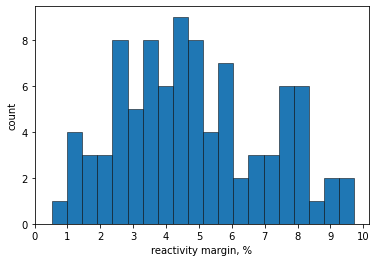

In [214]:
# Построим разброс значений целевой переменной
plt.hist(main_df.reactivity_margin, bins=20, linewidth=0.5, edgecolor="black")
plt.xlabel('reactivity margin, %')
plt.ylabel('count')
plt.xticks(list(range(11)))
plt.show()

В целом явно выпадающих значений нет, большая часть значений лежит от 3 до 5%, что соответствуеют типичному циклу работы реактора

In [215]:
# Поскольку реактивность зависит только от Кэф, удаляем данный столбец
main_df.drop(columns=['Keff'], inplace=True)
target = main_df.pop('reactivity_margin')
# Разделяем данные на обучающие и тестовые
X_train, X_test, y_train, y_test = train_test_split(main_df, target, test_size=0.3, random_state=7)
# Проверяем раззмерности обуч. и тест. наборов
X_train.shape, X_test.shape

((63, 172800), (28, 172800))

## Sklearn модели

In [4]:
# Для начала протестируем самую простую модель наименьших квадратов, а также три модели посложнее, линейную модель,
# которая минимизирует лосс с помощью стохастического градиентного спуска, линейную модель опорных векторов и модель опорных
# векторов с ядерным трюком. Для более сложных моделей будем подбирать оптимальный параметры с помощью HalvingGridSearch
lr = LinearRegression(n_jobs=-1)

sgd = SGDRegressor()

sgd_params = {
    'penalty':['l2', 'elasticnet'],
    'alpha':[0.0001, 0.001, 0.005],
    'l1_ratio':[0.15, 0.25, 0.5, 0.65, 0.75],
    'fit_intercept':[True],
    'tol':[0.0005],
    'max_iter':[50000]
}

lin_svr = LinearSVR()
             
lin_svr_params = {
    'tol':[0.0005],
    'C':[0.1, 0.5, 1, 10],
    'max_iter':[50000]
}

svr = SVR()

svr_params = {
    'kernel':['linear', 'poly', 'rbf', 'sigmoid'],
    'tol': [0.0005], 
    'C': np.logspace(-3,2, 6),
    'max_iter': [-1]
}


In [5]:
# Поскольку решается задача регрессии, то для поиска параметров можно ограничиться обычной k-блочной перекрестной проверкой
sss = KFold(n_splits=3, shuffle=True, random_state=7)

In [218]:
%%time 
# Обучаем модели
lr.fit(X_train, y_train)

sgd_search = HalvingGridSearchCV(estimator=sgd, 
                                 param_grid=sgd_params,
                                 scoring='r2',
                                 cv=sss, 
                                 random_state=7,
                                 n_jobs=-1).fit(X_train, y_train)

lin_svr_search = HalvingGridSearchCV(estimator=lin_svr, 
                                     param_grid=lin_svr_params,
                                     scoring='r2',
                                     cv=sss, 
                                     random_state=7,
                                     n_jobs=-1).fit(X_train, y_train)

svr_search = HalvingGridSearchCV(estimator=svr, 
                                 param_grid=svr_params,
                                 scoring='r2',
                                 cv=sss, 
                                 random_state=7,
                                 n_jobs=-1).fit(X_train, y_train)


Wall time: 4min 29s


In [219]:
#Глядя на ошибку обычной линейной модели, можно сделать вывод, что данная модель для решения задачи не подходит
mean_absolute_error(y_test, lr.predict(X_test))

494.363415440665

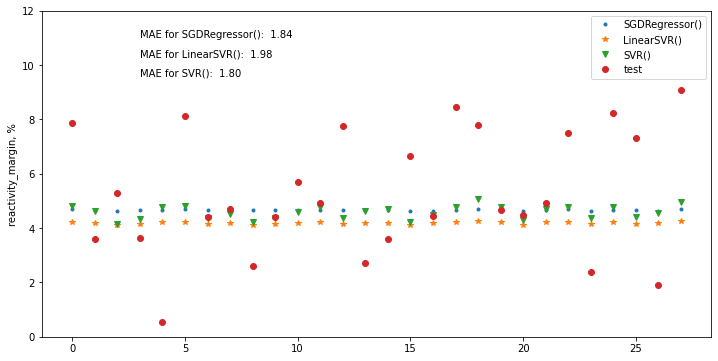

In [220]:
models = [sgd_search, lin_svr_search, svr_search]
markers = ['.', '*', 'v']
fig, ax = plt.subplots(figsize=(12,6))
for model, marker, y_text in zip(models, markers, [11,10.3,9.6]):
    y_pred = model.predict(X_test)
    ax.plot(y_pred, marker, label=(model.estimator))
    ax.text(s=f'MAE for {model.estimator}: {mean_absolute_error(y_test, y_pred): .2f}', x=3, y=y_text)
ax.plot([x for x in range(len(y_test))], y_test, 'o', label='test')
ax.set_ylabel('reactivity_margin, %')
ax.set_ylim(0, 12)
ax.legend()
plt.show()

## Вывод
Регрессионные модели способны предсказывать с довольно большой погрешностью, что может быть связано с влиянием различных ампульных устройств в отражателе, в особоенности ампулы в ячейке 6-4

In [2]:
# в файле final_with_ampules.csv помимо изотопных составов также имеется информация о ампуле в ячейке 6-4, которая
# уменьшает запас реактивности на порядка 2%. Это можно учесть просто вычев или прибавив данное значение, но 
# для начала можно попробовать учесть это простой индекацией наличия данной ампулы.
main_df2 = pd.read_csv('final_with_ampules.csv', sep=',', index_col=0 )

In [3]:
#Посчитаем кол-во вариантов с ампулой и без и соответствующие запасы
main_df2.groupby('ampule').agg({'Keff':'count', 'reactivity_margin':'mean'})

,Keff,reactivity_margin
ampule,,
0,22,4.867830
1,68,4.929305


In [4]:
main_df2.drop(columns=['Keff'], inplace=True)
target2 = main_df2.pop('reactivity_margin')

C:\Users\Anton\AppData\Local\Temp/ipykernel_1660/876083021.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df_avg_conc[f'avg_c_in_{num_matr}_to_{num_matr+NUM_ZONES_PER_FE-1}_for_{nuclide}'] = main_df2.filter(items = [f'{nuclide} in mat{num}' for num in range(num_matr, num_matr+NUM_ZONES_PER_FE)], axis=1).apply(axis=1, func=np.mean)


,avg_c_in_15563_to_15922_for_u235,avg_c_in_15923_to_16282_for_u235,avg_c_in_16283_to_16642_for_u235,avg_c_in_16643_to_17002_for_u235,avg_c_in_17003_to_17362_for_u235,avg_c_in_17363_to_17722_for_u235,avg_c_in_17723_to_18082_for_u235,avg_c_in_18083_to_18442_for_u235,avg_c_in_18443_to_18802_for_u235,avg_c_in_18803_to_19162_for_u235,...,avg_c_in_46523_to_46882_for_sm49,avg_c_in_46883_to_47242_for_sm49,avg_c_in_47243_to_47602_for_sm49,avg_c_in_47603_to_47962_for_sm49,avg_c_in_47963_to_48322_for_sm49,avg_c_in_48323_to_48682_for_sm49,avg_c_in_48683_to_49042_for_sm49,avg_c_in_49043_to_49402_for_sm49,avg_c_in_49403_to_49762_for_sm49,avg_c_in_49763_to_50122_for_sm49
0,0.001258,0.001274,0.001283,0.001288,0.001287,0.001279,0.001745,0.001756,0.001763,0.001766,...,3.062928e-07,3.056739e-07,3.075975e-07,3.130251e-07,2.325608e-07,2.320271e-07,2.320205e-07,2.327532e-07,2.343023e-07,2.371966e-07
1,0.001258,0.001274,0.001283,0.001288,0.001287,0.001279,0.001745,0.001756,0.001763,0.001766,...,3.062928e-07,3.056739e-07,3.075975e-07,3.130251e-07,2.325608e-07,2.320271e-07,2.320205e-07,2.327532e-07,2.343023e-07,2.371966e-07
2,0.001258,0.001274,0.001283,0.001288,0.001287,0.001279,0.001745,0.001756,0.001763,0.001766,...,3.062928e-07,3.056739e-07,3.075975e-07,3.130251e-07,2.325608e-07,2.320271e-07,2.320205e-07,2.327532e-07,2.343023e-07,2.371966e-07
3,0.001258,0.001274,0.001283,0.001288,0.001287,0.001279,0.001745,0.001756,0.001763,0.001766,...,3.062928e-07,3.056739e-07,3.075975e-07,3.130251e-07,2.325608e-07,2.320271e-07,2.320205e-07,2.327532e-07,2.343023e-07,2.371966e-07
4,0.001120,0.001135,0.001143,0.001147,0.001144,0.001133,0.001621,0.001634,0.001642,0.001645,...,2.723002e-07,2.719446e-07,2.729689e-07,2.762814e-07,2.044777e-07,2.043944e-07,2.045678e-07,2.049895e-07,2.058990e-07,2.074468e-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,0.001731,0.001722,0.001673,0.001698,0.001716,0.001658,0.001204,0.001213,0.001184,0.001196,...,1.744768e-07,1.783566e-07,1.800168e-07,1.748016e-07,2.180973e-07,2.163685e-07,2.088396e-07,2.135990e-07,2.138828e-07,2.135722e-07
86,0.001715,0.001707,0.001659,0.001683,0.001701,0.001643,0.001193,0.001202,0.001174,0.001185,...,1.161421e-07,1.186566e-07,1.191609e-07,1.144789e-07,1.565044e-07,1.568710e-07,1.521704e-07,1.559188e-07,1.555900e-07,1.537947e-07
87,0.001687,0.001680,0.001633,0.001657,0.001674,0.001617,0.001174,0.001184,0.001156,0.001166,...,1.221652e-07,1.249094e-07,1.258932e-07,1.217462e-07,1.599630e-07,1.594996e-07,1.543420e-07,1.579889e-07,1.578659e-07,1.567750e-07
88,0.001602,0.001598,0.001555,0.001579,0.001594,0.001537,0.001116,0.001126,0.001099,0.001109,...,2.226987e-07,2.278143e-07,2.309709e-07,2.263424e-07,2.657612e-07,2.612477e-07,2.510024e-07,2.562330e-07,2.571179e-07,2.585452e-07


In [5]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(main_df2, target2, test_size=0.2, random_state=7)

In [10]:
%%time
#В качестве первого шага применим аналогичные модели
sgd_search = HalvingGridSearchCV(estimator=sgd, 
                                 param_grid=sgd_params,
                                 scoring='r2',
                                 cv=sss, 
                                 random_state=9,
                                 n_jobs=-1).fit(X_train2, y_train2)

lin_svr_search = HalvingGridSearchCV(estimator=lin_svr, 
                                     param_grid=lin_svr_params,
                                     scoring='r2',
                                     cv=sss, 
                                     random_state=9,
                                     n_jobs=-1).fit(X_train2, y_train2)

svr_search = HalvingGridSearchCV(estimator=svr, 
                                 param_grid=svr_params,
                                 scoring='r2',
                                 cv=sss, 
                                 random_state=9,
                                 n_jobs=-1).fit(X_train2, y_train2)

Wall time: 6min 24s


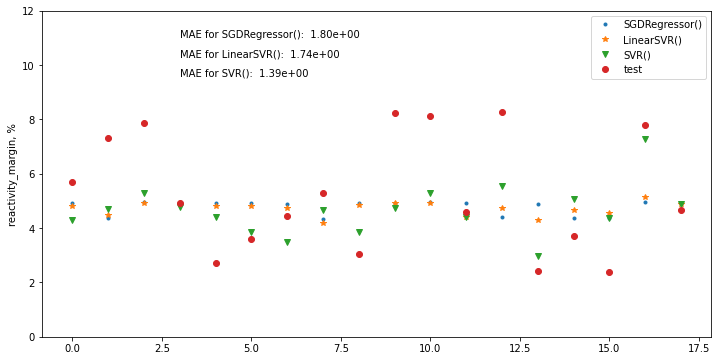

In [11]:
models = [sgd_search, lin_svr_search, svr_search]
markers = ['.', '*', 'v']
fig, ax = plt.subplots(figsize=(12,6))
for model, marker, y_text in zip(models, markers, [11,10.3,9.6]):
    y_pred = model.predict(X_test2)
    ax.plot(y_pred, marker, label=(model.estimator))
    ax.text(s=f'MAE for {model.estimator}: {mean_absolute_error(y_test2, y_pred): .2e}', x=3, y=y_text)
ax.plot([x for x in range(len(y_test2))], y_test2, 'o', label='test')
ax.set_ylabel('reactivity_margin, %')
ax.set_ylim(0, 12)
ax.legend()
plt.show()

## Вывод
Добавив 1 признак наличия ампулы к уже имеющимся **172800**, удалось **снизить** абсолютную ошибку с **2** до **1.4** <div>
**Наилучшей** моделью из рассмотренных оказалась **SVC**, что связано с большой нелинейностью зависимости целевой переменной от признаков

## Библиотека XGBoost + Optuna

In [36]:
# !pip install xgboost
# !pip install optuna
import xgboost as xgb
import optuna

In [9]:
def objective(trial, data=main_df2, label=target2):
    train_x, valid_x, train_y, valid_y = train_test_split(data, label, test_size=0.25)
    dtrain = xgb.DMatrix(train_x, label=train_y)
    dvalid = xgb.DMatrix(valid_x, label=valid_y)

    param = {
        "verbosity": 2,
        "objective": "reg:squarederror",
        "num_round": trial.suggest_int("num_round", 1000, 4000, step=500),
        # For larger dataset, approximate algorithm (approx) will be chosen.
        # Also it’s recommended to try hist and gpu_hist for higher performance with large dataset.
        "tree_method": "approx",
        # defines booster, gblinear for linear functions.
        "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
        # L2 regularization weight.
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        # L1 regularization weight.
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        # sampling ratio for training data. XGBoost would randomly sample half of the training data prior to growing trees
        # and this will prevent overfitting.
        "subsample": trial.suggest_float("subsample", 0.2, 1.0),
        # sampling according to each tree.
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
    }

    if param["booster"] in ["gbtree", "dart"]:
        # maximum depth of the tree, signifies complexity of the tree.
        param["max_depth"] = trial.suggest_int("max_depth", 2, 4, step=1)
        # minimum child weight, larger the term more conservative the tree.
        param["min_child_weight"] = trial.suggest_int("min_child_weight", 2, 10)
        param["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
        # defines how selective algorithm is.
        param["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
        param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])

    if param["booster"] == "dart":
        param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
        param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
        param["rate_drop"] = trial.suggest_float("rate_drop", 1e-8, 1.0, log=True)
        param["skip_drop"] = trial.suggest_float("skip_drop", 1e-8, 1.0, log=True)

    bst = xgb.train(param, dtrain)
    preds = bst.predict(dvalid)
    rmse = mean_squared_error(valid_y, preds, squared=False)
    return rmse

In [ ]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=300, timeout=None, n_jobs=3)

print("Number of finished trials: ", len(study.trials))
print(f"Best trial: {study.best_trial}") 

print(f"  Value: {trial.value}")
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2022-07-07 14:56:01,337] A new study created in memory with name: no-name-f73686d6-c19e-45a0-a444-e8ec0e43b58b
C:\Users\Anton\anaconda3\lib\site-packages\optuna\study\study.py:393: FutureWarning: `n_jobs` argument has been deprecated in v2.7.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.7.0.
  warnings.warn(
[I 2022-07-07 14:56:24,870] Trial 0 finished with value: 2.430555282752741 and parameters: {'num_round': 1800, 'booster': 'gblinear', 'lambda': 8.227760886309509e-05, 'alpha': 0.0005691009810988934, 'subsample': 0.49651343391372627, 'colsample_bytree': 0.4376722526734275}. Best is trial 0 with value: 2.430555282752741.
[I 2022-07-07 14:56:36,377] Trial 2 finished with value: 5.236896119942323 and parameters: {'num_round': 1800, 'booster': 'gbtree', 'lambda': 0.043488084432377165, 'alpha': 5.076240052645602e-06, 'subsample': 0.7655432660452626, 'colsample_bytree': 0.9498836492494249, 'max_depth': 2, 'min_child_weight': 3, 'eta': 0

[I 2022-07-07 15:00:21,699] Trial 18 finished with value: 5.390367561014091 and parameters: {'num_round': 1200, 'booster': 'gbtree', 'lambda': 9.967687997076664e-08, 'alpha': 0.06811103086406933, 'subsample': 0.9958571487362718, 'colsample_bytree': 0.5108706472997259, 'max_depth': 3, 'min_child_weight': 5, 'eta': 0.0005843056713221172, 'gamma': 2.1581692598993987e-05, 'grow_policy': 'lossguide'}. Best is trial 12 with value: 1.0113901692984892.
[I 2022-07-07 15:00:21,995] Trial 19 finished with value: 4.9187118444559035 and parameters: {'num_round': 1200, 'booster': 'gbtree', 'lambda': 3.3044484485748855e-08, 'alpha': 0.02621618880297237, 'subsample': 0.9676690745966772, 'colsample_bytree': 0.5391917491143224, 'max_depth': 3, 'min_child_weight': 5, 'eta': 0.00073317502029619, 'gamma': 2.4762463159503173e-05, 'grow_policy': 'lossguide'}. Best is trial 12 with value: 1.0113901692984892.
[I 2022-07-07 15:00:26,096] Trial 20 finished with value: 5.268041688835375 and parameters: {'num_roun

[I 2022-07-07 15:06:37,595] Trial 35 finished with value: 1.3384715711936834 and parameters: {'num_round': 2000, 'booster': 'dart', 'lambda': 3.146244115275389e-05, 'alpha': 0.0012308000148380633, 'subsample': 0.6126090558827442, 'colsample_bytree': 0.3336802323208302, 'max_depth': 4, 'min_child_weight': 10, 'eta': 0.6644770282947552, 'gamma': 0.04585402413811472, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.0029788770225999055, 'skip_drop': 1.1544550962501604e-08}. Best is trial 12 with value: 1.0113901692984892.
[I 2022-07-07 15:06:56,167] Trial 36 finished with value: 5.3268839392372485 and parameters: {'num_round': 1800, 'booster': 'dart', 'lambda': 5.634879768358497e-07, 'alpha': 1.3270940492993441e-05, 'subsample': 0.4688011395580942, 'colsample_bytree': 0.22332051432376548, 'max_depth': 4, 'min_child_weight': 10, 'eta': 4.983906419770144e-07, 'gamma': 0.001129720093503864, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'no

[I 2022-07-07 15:09:24,536] Trial 51 finished with value: 2.7229554535689062 and parameters: {'num_round': 1400, 'booster': 'dart', 'lambda': 1.4270712252836913e-08, 'alpha': 0.853230760538693, 'subsample': 0.23945152171561246, 'colsample_bytree': 0.4701140033147886, 'max_depth': 4, 'min_child_weight': 10, 'eta': 0.9951707474161858, 'gamma': 1.062450736752566e-08, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.00019025177638141438, 'skip_drop': 0.05163349254742995}. Best is trial 47 with value: 0.9131760592735361.
[I 2022-07-07 15:10:09,675] Trial 52 finished with value: 1.0671565974842119 and parameters: {'num_round': 2000, 'booster': 'dart', 'lambda': 1.1737189306985906e-06, 'alpha': 0.015638439698865133, 'subsample': 0.7849548387283576, 'colsample_bytree': 0.40902438412852865, 'max_depth': 4, 'min_child_weight': 7, 'eta': 0.3543336837811939, 'gamma': 0.0048179076939517404, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normaliz

[I 2022-07-07 15:25:28,306] Trial 69 finished with value: 4.337536209157202 and parameters: {'num_round': 1800, 'booster': 'dart', 'lambda': 0.24453017370123636, 'alpha': 0.09352013493016875, 'subsample': 0.8767823291422302, 'colsample_bytree': 0.9987319583120113, 'max_depth': 3, 'min_child_weight': 6, 'eta': 0.020887156573176694, 'gamma': 0.060650834709808185, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.013402420076569265, 'skip_drop': 0.10669168908346881}. Best is trial 47 with value: 0.9131760592735361.
[I 2022-07-07 15:25:28,368] Trial 67 finished with value: 4.938769699985421 and parameters: {'num_round': 1800, 'booster': 'dart', 'lambda': 0.0021958772887458833, 'alpha': 0.2941755343187844, 'subsample': 0.8567824578096948, 'colsample_bytree': 0.99451266460687, 'max_depth': 3, 'min_child_weight': 6, 'eta': 0.014996555320731866, 'gamma': 0.0004352672605138753, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type

[I 2022-07-07 16:36:57,270] Trial 83 finished with value: 1.5785141729367698 and parameters: {'num_round': 1200, 'booster': 'gbtree', 'lambda': 3.124474029746038e-06, 'alpha': 0.0015314525521278215, 'subsample': 0.9953524611504457, 'colsample_bytree': 0.6423257946145022, 'max_depth': 4, 'min_child_weight': 7, 'eta': 0.1068615778609044, 'gamma': 0.0008506055914695749, 'grow_policy': 'lossguide'}. Best is trial 47 with value: 0.9131760592735361.
[I 2022-07-07 16:36:59,442] Trial 82 finished with value: 3.4562903622348764 and parameters: {'num_round': 1200, 'booster': 'gbtree', 'lambda': 7.0988396783169875e-06, 'alpha': 0.0017369197140864243, 'subsample': 0.9722486527914258, 'colsample_bytree': 0.629429403374727, 'max_depth': 4, 'min_child_weight': 7, 'eta': 0.03912074913873038, 'gamma': 0.008976841687640954, 'grow_policy': 'lossguide'}. Best is trial 47 with value: 0.9131760592735361.
[I 2022-07-07 16:36:59,552] Trial 84 finished with value: 2.009422917499417 and parameters: {'num_round'

[I 2022-07-07 17:05:28,557] Trial 99 finished with value: 2.1993361561082274 and parameters: {'num_round': 1400, 'booster': 'gblinear', 'lambda': 2.0603462728121785e-08, 'alpha': 0.16931994429517924, 'subsample': 0.8622841579641364, 'colsample_bytree': 0.5618767320681476}. Best is trial 88 with value: 0.8877407743952134.
[I 2022-07-07 17:05:28,635] Trial 98 finished with value: 1.3947406837501617 and parameters: {'num_round': 1400, 'booster': 'gblinear', 'lambda': 4.6728464159812754e-07, 'alpha': 3.139289403673577e-06, 'subsample': 0.8656294875629816, 'colsample_bytree': 0.5535651471185415}. Best is trial 88 with value: 0.8877407743952134.
[I 2022-07-07 17:07:25,541] Trial 102 finished with value: 3.393345311944049 and parameters: {'num_round': 2000, 'booster': 'dart', 'lambda': 6.393780020497667e-07, 'alpha': 3.985650167612618e-08, 'subsample': 0.7740739661592447, 'colsample_bytree': 0.663655078103167, 'max_depth': 4, 'min_child_weight': 7, 'eta': 0.05063542685911479, 'gamma': 0.04111

[I 2022-07-07 17:11:10,220] Trial 114 finished with value: 1.3160485491357572 and parameters: {'num_round': 1800, 'booster': 'dart', 'lambda': 5.4592698581514695e-08, 'alpha': 0.024267542438143063, 'subsample': 0.6015700578991919, 'colsample_bytree': 0.24299988414930815, 'max_depth': 4, 'min_child_weight': 10, 'eta': 0.6005672229746578, 'gamma': 0.031277972326379654, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.10300946490748085, 'skip_drop': 0.5447220583184671}. Best is trial 106 with value: 0.7729210244544766.
[I 2022-07-07 17:11:10,938] Trial 112 finished with value: 1.0780924470980557 and parameters: {'num_round': 1800, 'booster': 'dart', 'lambda': 5.4281969083636526e-08, 'alpha': 0.021163418583992795, 'subsample': 0.6349590178198317, 'colsample_bytree': 0.391251761659751, 'max_depth': 4, 'min_child_weight': 10, 'eta': 0.6725476875766118, 'gamma': 0.0005575373806224553, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normaliz

[I 2022-07-07 17:15:17,406] Trial 128 finished with value: 2.5155980169761896 and parameters: {'num_round': 1800, 'booster': 'dart', 'lambda': 8.95455146943706e-07, 'alpha': 0.23026912441752817, 'subsample': 0.7325719731281635, 'colsample_bytree': 0.36263841119041373, 'max_depth': 4, 'min_child_weight': 10, 'eta': 0.07134232671614706, 'gamma': 0.004040671022571215, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.0001225733218382395, 'skip_drop': 0.01910386017241191}. Best is trial 106 with value: 0.7729210244544766.
[I 2022-07-07 17:15:19,702] Trial 130 finished with value: 1.470190229519847 and parameters: {'num_round': 1800, 'booster': 'dart', 'lambda': 1.1743408054876079e-06, 'alpha': 0.03454210446299013, 'subsample': 0.5413430091298302, 'colsample_bytree': 0.35629328887667316, 'max_depth': 4, 'min_child_weight': 10, 'eta': 0.18324379108817532, 'gamma': 0.1567599566621204, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize

[I 2022-07-07 17:22:32,061] Trial 145 finished with value: 1.1698020504740934 and parameters: {'num_round': 2000, 'booster': 'dart', 'lambda': 3.6158138168644865e-07, 'alpha': 0.0170718001405816, 'subsample': 0.8964760958789589, 'colsample_bytree': 0.288392435280711, 'max_depth': 4, 'min_child_weight': 10, 'eta': 0.8810792232434103, 'gamma': 0.012289905850100778, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.0031748839768481283, 'skip_drop': 0.042751897992318974}. Best is trial 106 with value: 0.7729210244544766.
[I 2022-07-07 17:22:32,108] Trial 143 finished with value: 1.098502758191897 and parameters: {'num_round': 2000, 'booster': 'dart', 'lambda': 4.02294602661843e-07, 'alpha': 0.01888127654131026, 'subsample': 0.895578704858783, 'colsample_bytree': 0.2531820699806269, 'max_depth': 4, 'min_child_weight': 10, 'eta': 0.9513426058646318, 'gamma': 0.011409680983737626, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_typ

[I 2022-07-07 17:26:02,869] Trial 159 finished with value: 2.048116957147524 and parameters: {'num_round': 1800, 'booster': 'gblinear', 'lambda': 9.13268574273984e-08, 'alpha': 0.028987539736236998, 'subsample': 0.707720479393189, 'colsample_bytree': 0.37051137024658637}. Best is trial 106 with value: 0.7729210244544766.
[I 2022-07-07 17:26:04,866] Trial 160 finished with value: 1.860264137527366 and parameters: {'num_round': 1800, 'booster': 'gblinear', 'lambda': 3.928619566890204e-08, 'alpha': 0.02949847997993717, 'subsample': 0.7037049362090005, 'colsample_bytree': 0.40886628773248435}. Best is trial 106 with value: 0.7729210244544766.
[I 2022-07-07 17:26:09,631] Trial 158 finished with value: 0.9473709440505679 and parameters: {'num_round': 1800, 'booster': 'dart', 'lambda': 2.940363680967826e-07, 'alpha': 0.02752516867990664, 'subsample': 0.851698707233464, 'colsample_bytree': 0.3748799020165568, 'max_depth': 2, 'min_child_weight': 10, 'eta': 0.6984984988185665, 'gamma': 0.0153293

[I 2022-07-07 17:28:46,634] Trial 173 finished with value: 0.8965075692077129 and parameters: {'num_round': 2000, 'booster': 'dart', 'lambda': 1.1797143300861065e-07, 'alpha': 0.03309996897703381, 'subsample': 0.8742891315484451, 'colsample_bytree': 0.37857157903171434, 'max_depth': 4, 'min_child_weight': 10, 'eta': 0.654243614700289, 'gamma': 0.012960914614934609, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.08844290281796843, 'skip_drop': 0.9444894725473495}. Best is trial 106 with value: 0.7729210244544766.
[I 2022-07-07 17:29:00,119] Trial 175 finished with value: 1.3435422543552495 and parameters: {'num_round': 2000, 'booster': 'dart', 'lambda': 1.3485283577832868e-07, 'alpha': 0.03549020956458979, 'subsample': 0.6621119015274146, 'colsample_bytree': 0.3564381288502467, 'max_depth': 4, 'min_child_weight': 10, 'eta': 0.45529561632919896, 'gamma': 0.10390373390133761, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_t

In [33]:
#Рассмотрение концентрации в каждой зоне объема весьма затратно, поэтому создидим новый df с усредненными по твэлам концентрациями
NUM_ZONES_PER_FE = 360
df_avg_conc = pd.DataFrame()
for nuclide in ['u235', 'u238', 'pu39', 'xe35', 'sm49']:
    for num_matr in range(15563, 50123, NUM_ZONES_PER_FE):
        df_avg_conc[f'avg_c_in_{num_matr}_to_{num_matr+NUM_ZONES_PER_FE-1}_for_{nuclide}'] = main_df2.filter(items = [f'{nuclide} in mat{num}' for num in range(num_matr, num_matr+NUM_ZONES_PER_FE)], axis=1).apply(axis=1, func=np.mean)
df_avg_conc

C:\Users\Anton\AppData\Local\Temp/ipykernel_1660/112415820.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df_avg_conc[f'avg_c_in_{num_matr}_to_{num_matr+NUM_ZONES_PER_FE-1}_for_{nuclide}'] = main_df2.filter(items = [f'{nuclide} in mat{num}' for num in range(num_matr, num_matr+NUM_ZONES_PER_FE)], axis=1).apply(axis=1, func=np.mean)


,avg_c_in_15563_to_15922_for_u235,avg_c_in_15923_to_16282_for_u235,avg_c_in_16283_to_16642_for_u235,avg_c_in_16643_to_17002_for_u235,avg_c_in_17003_to_17362_for_u235,avg_c_in_17363_to_17722_for_u235,avg_c_in_17723_to_18082_for_u235,avg_c_in_18083_to_18442_for_u235,avg_c_in_18443_to_18802_for_u235,avg_c_in_18803_to_19162_for_u235,...,avg_c_in_46523_to_46882_for_sm49,avg_c_in_46883_to_47242_for_sm49,avg_c_in_47243_to_47602_for_sm49,avg_c_in_47603_to_47962_for_sm49,avg_c_in_47963_to_48322_for_sm49,avg_c_in_48323_to_48682_for_sm49,avg_c_in_48683_to_49042_for_sm49,avg_c_in_49043_to_49402_for_sm49,avg_c_in_49403_to_49762_for_sm49,avg_c_in_49763_to_50122_for_sm49
0,0.001258,0.001274,0.001283,0.001288,0.001287,0.001279,0.001745,0.001756,0.001763,0.001766,...,3.062928e-07,3.056739e-07,3.075975e-07,3.130251e-07,2.325608e-07,2.320271e-07,2.320205e-07,2.327532e-07,2.343023e-07,2.371966e-07
1,0.001258,0.001274,0.001283,0.001288,0.001287,0.001279,0.001745,0.001756,0.001763,0.001766,...,3.062928e-07,3.056739e-07,3.075975e-07,3.130251e-07,2.325608e-07,2.320271e-07,2.320205e-07,2.327532e-07,2.343023e-07,2.371966e-07
2,0.001258,0.001274,0.001283,0.001288,0.001287,0.001279,0.001745,0.001756,0.001763,0.001766,...,3.062928e-07,3.056739e-07,3.075975e-07,3.130251e-07,2.325608e-07,2.320271e-07,2.320205e-07,2.327532e-07,2.343023e-07,2.371966e-07
3,0.001258,0.001274,0.001283,0.001288,0.001287,0.001279,0.001745,0.001756,0.001763,0.001766,...,3.062928e-07,3.056739e-07,3.075975e-07,3.130251e-07,2.325608e-07,2.320271e-07,2.320205e-07,2.327532e-07,2.343023e-07,2.371966e-07
4,0.001120,0.001135,0.001143,0.001147,0.001144,0.001133,0.001621,0.001634,0.001642,0.001645,...,2.723002e-07,2.719446e-07,2.729689e-07,2.762814e-07,2.044777e-07,2.043944e-07,2.045678e-07,2.049895e-07,2.058990e-07,2.074468e-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,0.001731,0.001722,0.001673,0.001698,0.001716,0.001658,0.001204,0.001213,0.001184,0.001196,...,1.744768e-07,1.783566e-07,1.800168e-07,1.748016e-07,2.180973e-07,2.163685e-07,2.088396e-07,2.135990e-07,2.138828e-07,2.135722e-07
86,0.001715,0.001707,0.001659,0.001683,0.001701,0.001643,0.001193,0.001202,0.001174,0.001185,...,1.161421e-07,1.186566e-07,1.191609e-07,1.144789e-07,1.565044e-07,1.568710e-07,1.521704e-07,1.559188e-07,1.555900e-07,1.537947e-07
87,0.001687,0.001680,0.001633,0.001657,0.001674,0.001617,0.001174,0.001184,0.001156,0.001166,...,1.221652e-07,1.249094e-07,1.258932e-07,1.217462e-07,1.599630e-07,1.594996e-07,1.543420e-07,1.579889e-07,1.578659e-07,1.567750e-07
88,0.001602,0.001598,0.001555,0.001579,0.001594,0.001537,0.001116,0.001126,0.001099,0.001109,...,2.226987e-07,2.278143e-07,2.309709e-07,2.263424e-07,2.657612e-07,2.612477e-07,2.510024e-07,2.562330e-07,2.571179e-07,2.585452e-07


In [ ]:
def objective(trial, data=df_avg_conc, label=target2):
    train_x, valid_x, train_y, valid_y = train_test_split(data, label, test_size=0.25)
    dtrain = xgb.DMatrix(train_x, label=train_y)
    dvalid = xgb.DMatrix(valid_x, label=valid_y)

    param = {
        "verbosity": 1,
        "objective": "reg:squarederror",
        "num_round": trial.suggest_int("num_round", 3000, 30000, step=1000),
        # For larger dataset, approximate algorithm (approx) will be chosen.
        # Also it’s recommended to try hist and gpu_hist for higher performance with large dataset.
        "tree_method": trial.suggest_categorical("tree_method",["approx", "hist"]),
        # defines booster, gblinear for linear functions.
        "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
        # L2 regularization weight.
        "lambda": trial.suggest_float("lambda", 1e-8, 100.0, log=True),
        # L1 regularization weight.
        "alpha": trial.suggest_float("alpha", 1e-8, 100.0, log=True),
        # sampling ratio for training data. XGBoost would randomly sample half of the training data prior to growing trees
        # and this will prevent overfitting.
        "subsample": trial.suggest_float("subsample", 0.2, 1.0),
        # sampling according to each tree.
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
    }

    if param["booster"] in ["gbtree", "dart"]:
        # maximum depth of the tree, signifies complexity of the tree.
        param["max_depth"] = trial.suggest_int("max_depth", 2, 20, step=1)
        # minimum child weight, larger the term more conservative the tree.
        param["min_child_weight"] = trial.suggest_int("min_child_weight", 2, 10)
        param["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
        # defines how selective algorithm is.
        param["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
        param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])

    if param["booster"] == "dart":
        param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
        param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
        param["rate_drop"] = trial.suggest_float("rate_drop", 1e-8, 1.0, log=True)
        param["skip_drop"] = trial.suggest_float("skip_drop", 1e-8, 1.0, log=True)

    bst = xgb.train(param, dtrain)
    preds = bst.predict(dvalid)
    rmse = mean_squared_error(valid_y, preds, squared=False)
    return rmse

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=5000, timeout=None, n_jobs=3)

print("Number of finished trials: ", len(study.trials))
trial=study.best_trial
print(f"Best trial: {trial}") 

print(f"  Value: {trial.value}")
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2022-07-11 16:27:29,294] A new study created in memory with name: no-name-e9c8be2d-20b6-452c-948a-6a53dc8321b5
C:\Users\Anton\anaconda3\lib\site-packages\optuna\study\study.py:393: FutureWarning: `n_jobs` argument has been deprecated in v2.7.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.7.0.
  warnings.warn(
[I 2022-07-11 16:27:29,398] Trial 0 finished with value: 5.080749669725075 and parameters: {'num_round': 9000, 'tree_method': 'hist', 'booster': 'gbtree', 'lambda': 6.575932006086575e-06, 'alpha': 4.115460005313986e-05, 'subsample': 0.363843554229814, 'colsample_bytree': 0.6128114371244884, 'max_depth': 10, 'min_child_weight': 8, 'eta': 1.919826758456219e-08, 'gamma': 4.268234621368667e-05, 'grow_policy': 'lossguide'}. Best is trial 0 with value: 5.080749669725075.
[I 2022-07-11 16:27:29,447] Trial 3 finished with value: 1.6981004235651243 and parameters: {'num_round': 19000, 'tree_method': 'hist', 'booster': 'gblinear', 'lambda'

[I 2022-07-11 16:27:30,197] Trial 19 finished with value: 1.734430260671193 and parameters: {'num_round': 26000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 0.042086499280437346, 'alpha': 37.59815668774194, 'subsample': 0.8158025453467758, 'colsample_bytree': 0.49739856307715297, 'max_depth': 19, 'min_child_weight': 4, 'eta': 0.9756320476213662, 'gamma': 1.4961695794766657e-08, 'grow_policy': 'depthwise'}. Best is trial 3 with value: 1.6981004235651243.
[I 2022-07-11 16:27:30,253] Trial 20 finished with value: 4.520361861560283 and parameters: {'num_round': 18000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 0.02113240461532213, 'alpha': 75.75312965134086, 'subsample': 0.8105170111444344, 'colsample_bytree': 0.4989120602624343, 'max_depth': 19, 'min_child_weight': 4, 'eta': 8.087117392340815e-06, 'gamma': 1.547630612177841e-08, 'grow_policy': 'depthwise'}. Best is trial 3 with value: 1.6981004235651243.
[I 2022-07-11 16:27:30,259] Trial 21 finished with value: 5.

[I 2022-07-11 16:27:31,844] Trial 36 finished with value: 0.9023867538666047 and parameters: {'num_round': 28000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 0.002058261592467278, 'alpha': 0.16903016383592445, 'subsample': 0.923711435907433, 'colsample_bytree': 0.4190829701545167, 'max_depth': 9, 'min_child_weight': 5, 'eta': 0.19881435514430065, 'gamma': 8.8765081048167e-06, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 1.4288569330004936e-08, 'skip_drop': 0.662045843088818}. Best is trial 25 with value: 0.8520700677762204.
[I 2022-07-11 16:27:31,847] Trial 37 finished with value: 1.060516407983157 and parameters: {'num_round': 28000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 0.16966421570737814, 'alpha': 0.31166663575088976, 'subsample': 0.7630826853325601, 'colsample_bytree': 0.42179721783516805, 'max_depth': 20, 'min_child_weight': 5, 'eta': 0.24674477222433253, 'gamma': 1.3052145416975892e-05, 'grow_policy': 'dep

[I 2022-07-11 16:27:32,932] Trial 51 finished with value: 4.463114387231098 and parameters: {'num_round': 9000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 7.726114631040674e-07, 'alpha': 13.281566172282853, 'subsample': 0.9086090064756388, 'colsample_bytree': 0.6546392659314735, 'max_depth': 14, 'min_child_weight': 7, 'eta': 1.0423856633005234e-07, 'gamma': 1.2139554255995781e-06, 'grow_policy': 'lossguide'}. Best is trial 25 with value: 0.8520700677762204.
[I 2022-07-11 16:27:32,948] Trial 50 finished with value: 2.9493275872769984 and parameters: {'num_round': 16000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 4.5094668260404464e-07, 'alpha': 0.010486777385945702, 'subsample': 0.9066317441965067, 'colsample_bytree': 0.6222404938126097, 'max_depth': 14, 'min_child_weight': 8, 'eta': 0.05368380951170949, 'gamma': 7.651193565389499e-07, 'grow_policy': 'depthwise'}. Best is trial 25 with value: 0.8520700677762204.
[I 2022-07-11 16:27:32,986] Trial 52 finished wit

[I 2022-07-11 16:27:34,043] Trial 63 finished with value: 0.8913146886329036 and parameters: {'num_round': 13000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 1.6996856586696383e-06, 'alpha': 0.0014517831712611792, 'subsample': 0.9644060316757597, 'colsample_bytree': 0.48736583377695847, 'max_depth': 10, 'min_child_weight': 8, 'eta': 0.5597535214842723, 'gamma': 3.8159265607131915e-06, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.0041110946355670365, 'skip_drop': 0.08672475648675299}. Best is trial 25 with value: 0.8520700677762204.
[I 2022-07-11 16:27:34,270] Trial 66 finished with value: 1.6195022710434281 and parameters: {'num_round': 14000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 7.368262240014904e-07, 'alpha': 9.1003634115593e-05, 'subsample': 0.891291742511108, 'colsample_bytree': 0.4842823544906725, 'max_depth': 5, 'min_child_weight': 8, 'eta': 0.9195229883139221, 'gamma': 1.660259341604182e-06, 'grow_poli

[I 2022-07-11 16:27:35,306] Trial 80 finished with value: 2.352426967231113 and parameters: {'num_round': 14000, 'tree_method': 'approx', 'booster': 'gblinear', 'lambda': 14.936929148096212, 'alpha': 0.007083857002400396, 'subsample': 0.8388859444246581, 'colsample_bytree': 0.22708743136007223}. Best is trial 25 with value: 0.8520700677762204.
[I 2022-07-11 16:27:35,312] Trial 81 finished with value: 2.5293586099856937 and parameters: {'num_round': 14000, 'tree_method': 'approx', 'booster': 'gblinear', 'lambda': 2.7879001149352555e-06, 'alpha': 0.0008810434802229345, 'subsample': 0.8774440827268469, 'colsample_bytree': 0.4724495752555429}. Best is trial 25 with value: 0.8520700677762204.
[I 2022-07-11 16:27:35,366] Trial 79 finished with value: 1.1009736925041693 and parameters: {'num_round': 10000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 9.749622726248818e-06, 'alpha': 0.0010267754902278433, 'subsample': 0.8988539822377927, 'colsample_bytree': 0.23370269745451838, 'max_d

[I 2022-07-11 16:27:36,665] Trial 94 finished with value: 0.9415042900054623 and parameters: {'num_round': 16000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 0.058283175727930944, 'alpha': 0.0005148253330043937, 'subsample': 0.6501671994368051, 'colsample_bytree': 0.8861987268525113, 'max_depth': 7, 'min_child_weight': 8, 'eta': 0.29795867377948, 'gamma': 4.3022318339281455e-06, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 1.9685103660451759e-07, 'skip_drop': 0.0037504122888227976}. Best is trial 25 with value: 0.8520700677762204.
[I 2022-07-11 16:27:36,866] Trial 96 finished with value: 1.6863005469939478 and parameters: {'num_round': 14000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 0.039764220455047274, 'alpha': 0.00016398021965508027, 'subsample': 0.623855612416033, 'colsample_bytree': 0.9119247454760379, 'max_depth': 6, 'min_child_weight': 8, 'eta': 0.12143549400022137, 'gamma': 1.6076125662429436e-06, 'grow_poli

[I 2022-07-11 16:27:38,003] Trial 109 finished with value: 1.1473887000568534 and parameters: {'num_round': 30000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 7.530046921503205e-08, 'alpha': 1.3038278995152741, 'subsample': 0.7852625223935745, 'colsample_bytree': 0.8388796761943543, 'max_depth': 11, 'min_child_weight': 3, 'eta': 0.7363274687259133, 'gamma': 3.855787930346414e-06, 'grow_policy': 'lossguide'}. Best is trial 25 with value: 0.8520700677762204.
[I 2022-07-11 16:27:38,028] Trial 110 finished with value: 1.8707992770102537 and parameters: {'num_round': 29000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 8.900258503337758, 'alpha': 1.0376404721271586, 'subsample': 0.652100195716899, 'colsample_bytree': 0.8515701390506702, 'max_depth': 7, 'min_child_weight': 8, 'eta': 0.6075043357070081, 'gamma': 0.0001419494618403683, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.36242248118934783, 'skip_drop': 3.44705511290

[I 2022-07-11 16:27:39,204] Trial 124 finished with value: 1.1727788296035488 and parameters: {'num_round': 29000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 2.0758453347131056e-06, 'alpha': 0.0006885216394007889, 'subsample': 0.9553870838674673, 'colsample_bytree': 0.24578319977113078, 'max_depth': 9, 'min_child_weight': 8, 'eta': 0.6473230540295809, 'gamma': 2.1742016914967295e-06, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.0008689115185713025, 'skip_drop': 0.0003164940235852955}. Best is trial 25 with value: 0.8520700677762204.
[I 2022-07-11 16:27:39,308] Trial 126 finished with value: 0.9068992312776447 and parameters: {'num_round': 3000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 2.050437495913727e-06, 'alpha': 0.0009692813843665411, 'subsample': 0.9558882390424099, 'colsample_bytree': 0.2026602465762608, 'max_depth': 9, 'min_child_weight': 8, 'eta': 0.5925574592157536, 'gamma': 6.880208385203738e-06, 'grow_

[I 2022-07-11 16:27:40,759] Trial 140 finished with value: 1.2084224708710305 and parameters: {'num_round': 28000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 2.0673736001534932e-06, 'alpha': 6.218163762466557e-06, 'subsample': 0.9866437284851105, 'colsample_bytree': 0.6078533816775479, 'max_depth': 15, 'min_child_weight': 8, 'eta': 0.4421500853289915, 'gamma': 0.0004480993703732759, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 6.366438532974941e-06, 'skip_drop': 0.0163152961149884}. Best is trial 25 with value: 0.8520700677762204.
[I 2022-07-11 16:27:40,830] Trial 141 finished with value: 1.5321414105067552 and parameters: {'num_round': 28000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 30.217076035028164, 'alpha': 0.00011879729610120704, 'subsample': 0.9840055650252593, 'colsample_bytree': 0.3937956453794086, 'max_depth': 9, 'min_child_weight': 8, 'eta': 0.50454700575661, 'gamma': 8.41810810037872e-05, 'grow_policy': '

[I 2022-07-11 16:27:41,895] Trial 155 finished with value: 1.1635661972189737 and parameters: {'num_round': 29000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 8.197577763538314e-07, 'alpha': 0.00010250250000845873, 'subsample': 0.5848491058627256, 'colsample_bytree': 0.643700830183205, 'max_depth': 10, 'min_child_weight': 8, 'eta': 0.573784529722814, 'gamma': 0.006171721814073627, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 6.040738890030397e-05, 'skip_drop': 0.04506781180178643}. Best is trial 25 with value: 0.8520700677762204.
[I 2022-07-11 16:27:42,202] Trial 156 finished with value: 0.9117763636045655 and parameters: {'num_round': 27000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 0.0012128792743911166, 'alpha': 0.00022923631994202932, 'subsample': 0.5209636124287794, 'colsample_bytree': 0.9169342911407878, 'max_depth': 5, 'min_child_weight': 4, 'eta': 0.37146119464235783, 'gamma': 0.0023421765481604663, 'grow_pol

[I 2022-07-11 16:27:43,423] Trial 170 finished with value: 0.9783975763222195 and parameters: {'num_round': 13000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 2.840312673949465e-06, 'alpha': 0.06294382710258957, 'subsample': 0.6963902346692924, 'colsample_bytree': 0.3606482417338637, 'max_depth': 10, 'min_child_weight': 7, 'eta': 0.39381432454944904, 'gamma': 3.306940925036005e-06, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.012370425262190411, 'skip_drop': 0.059497147398227826}. Best is trial 25 with value: 0.8520700677762204.
[I 2022-07-11 16:27:43,493] Trial 171 finished with value: 1.1534198355506826 and parameters: {'num_round': 12000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 5.326128666675906e-08, 'alpha': 0.0012031229242235233, 'subsample': 0.6887481578258231, 'colsample_bytree': 0.5125193335299565, 'max_depth': 10, 'min_child_weight': 7, 'eta': 0.36621638351657637, 'gamma': 8.681977997844578e-06, 'grow_p

[I 2022-07-11 16:27:44,718] Trial 184 finished with value: 1.400123423202641 and parameters: {'num_round': 14000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 2.796750091342675e-07, 'alpha': 0.03855368921762952, 'subsample': 0.7607890111749471, 'colsample_bytree': 0.20279191063594615, 'max_depth': 9, 'min_child_weight': 6, 'eta': 0.512929192590735, 'gamma': 0.014899920874483384, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.0013886779669282246, 'skip_drop': 0.0001425868558695383}. Best is trial 176 with value: 0.7748834779246508.
[I 2022-07-11 16:27:44,744] Trial 185 finished with value: 1.3557176397938102 and parameters: {'num_round': 15000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 1.2326323334162422e-07, 'alpha': 0.11469597645033658, 'subsample': 0.7675320801232401, 'colsample_bytree': 0.22639701462995193, 'max_depth': 9, 'min_child_weight': 6, 'eta': 0.5363599089925365, 'gamma': 0.011232335355524896, 'grow_policy

[I 2022-07-11 16:27:46,348] Trial 199 finished with value: 1.3009835933931682 and parameters: {'num_round': 12000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 1.6696525959376904e-07, 'alpha': 0.049316375671596815, 'subsample': 0.842173024935455, 'colsample_bytree': 0.5348568316639648, 'max_depth': 7, 'min_child_weight': 5, 'eta': 0.6006755848966953, 'gamma': 0.002024846474882851, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.0013619872731880469, 'skip_drop': 0.00010933334027547725}. Best is trial 176 with value: 0.7748834779246508.
[I 2022-07-11 16:27:46,417] Trial 201 finished with value: 1.1407700362016695 and parameters: {'num_round': 11000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 1.4941684784427654e-07, 'alpha': 0.0005131164451334038, 'subsample': 0.9702165230357418, 'colsample_bytree': 0.24387383461744583, 'max_depth': 7, 'min_child_weight': 5, 'eta': 0.5741636079359249, 'gamma': 0.0018482767226954164, 'grow_

[I 2022-07-11 16:27:47,827] Trial 213 finished with value: 1.2916268750604023 and parameters: {'num_round': 14000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 1.0705896953715446, 'alpha': 0.0004782861421589017, 'subsample': 0.4900717658509852, 'colsample_bytree': 0.7285504607972004, 'max_depth': 2, 'min_child_weight': 6, 'eta': 0.9222685455051545, 'gamma': 4.877315344051265e-06, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 8.969877047843989e-05, 'skip_drop': 1.6565266663889377e-06}. Best is trial 176 with value: 0.7748834779246508.
[I 2022-07-11 16:27:47,870] Trial 214 finished with value: 1.3594242962380094 and parameters: {'num_round': 14000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 1.8128455016875604e-06, 'alpha': 0.0010134737472747189, 'subsample': 0.5009499840981408, 'colsample_bytree': 0.7212874465704323, 'max_depth': 5, 'min_child_weight': 6, 'eta': 0.9787125305383984, 'gamma': 4.315565476773997e-06, 'grow_

[I 2022-07-11 16:27:49,095] Trial 228 finished with value: 1.6336872504447975 and parameters: {'num_round': 13000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 3.521050664404024e-07, 'alpha': 0.05724164803294486, 'subsample': 0.9475102543134624, 'colsample_bytree': 0.2957047881021781, 'max_depth': 3, 'min_child_weight': 4, 'eta': 0.7061900849283017, 'gamma': 0.002456858804943455, 'grow_policy': 'lossguide'}. Best is trial 224 with value: 0.7706525273638949.
[I 2022-07-11 16:27:49,118] Trial 226 finished with value: 0.8315675772163013 and parameters: {'num_round': 15000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 1.7946599740679274, 'alpha': 0.09539576507621898, 'subsample': 0.9505203781129992, 'colsample_bytree': 0.29879723664025015, 'max_depth': 6, 'min_child_weight': 4, 'eta': 0.7073710356372163, 'gamma': 0.002960194878647209, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.007875633671060688, 'skip_drop': 5.1437

[I 2022-07-11 16:27:50,427] Trial 241 finished with value: 1.2788319272069304 and parameters: {'num_round': 29000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 2.957758579608543, 'alpha': 0.1530660364856105, 'subsample': 0.9195648045191449, 'colsample_bytree': 0.22059350994609375, 'max_depth': 7, 'min_child_weight': 4, 'eta': 0.6335670137560372, 'gamma': 0.0008160384173219417, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 0.0019039768182694536, 'skip_drop': 3.602313080646058e-07}. Best is trial 224 with value: 0.7706525273638949.
[I 2022-07-11 16:27:50,533] Trial 242 finished with value: 1.5497567801986443 and parameters: {'num_round': 14000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 12.254505652422917, 'alpha': 0.1580103893546958, 'subsample': 0.9340223198147419, 'colsample_bytree': 0.47170597771222833, 'max_depth': 15, 'min_child_weight': 8, 'eta': 0.2641765629530656, 'gamma': 0.004520907223978519, 'grow_policy': '

[I 2022-07-11 16:27:51,933] Trial 258 finished with value: 1.0982449814152409 and parameters: {'num_round': 28000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 7.507616601296555e-07, 'alpha': 0.0002331696727612153, 'subsample': 0.9872868825744261, 'colsample_bytree': 0.24160225384528045, 'max_depth': 8, 'min_child_weight': 8, 'eta': 0.30596910750462186, 'gamma': 3.4268772578499986e-06, 'grow_policy': 'lossguide'}. Best is trial 224 with value: 0.7706525273638949.
[I 2022-07-11 16:27:51,934] Trial 257 finished with value: 1.0064316695544828 and parameters: {'num_round': 27000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 5.76052741787175e-07, 'alpha': 0.00019386428708387552, 'subsample': 0.983701362860371, 'colsample_bytree': 0.4876244047681754, 'max_depth': 8, 'min_child_weight': 8, 'eta': 0.2716341136700131, 'gamma': 3.432966820338249e-06, 'grow_policy': 'lossguide'}. Best is trial 224 with value: 0.7706525273638949.
[I 2022-07-11 16:27:52,067] Trial 259 finished

[I 2022-07-11 16:27:53,304] Trial 271 finished with value: 1.427015244720227 and parameters: {'num_round': 16000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 0.0028989828627518257, 'alpha': 0.22909785557009502, 'subsample': 0.8482071870986925, 'colsample_bytree': 0.28901585068279856, 'max_depth': 9, 'min_child_weight': 8, 'eta': 0.9600983956810035, 'gamma': 0.0014745017617992448, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.019406374878228307, 'skip_drop': 0.00013176680983897568}. Best is trial 224 with value: 0.7706525273638949.
[I 2022-07-11 16:27:53,419] Trial 273 finished with value: 1.2540421133516328 and parameters: {'num_round': 15000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 2.1575284394863656, 'alpha': 0.0004339593686955569, 'subsample': 0.9310161446282754, 'colsample_bytree': 0.3069246430060197, 'max_depth': 14, 'min_child_weight': 8, 'eta': 0.9900323227760577, 'gamma': 0.0013167314558425926, 'grow_polic

[I 2022-07-11 16:27:54,768] Trial 287 finished with value: 1.1939591937402665 and parameters: {'num_round': 14000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 0.38570485638127194, 'alpha': 0.047774310166839376, 'subsample': 0.7866896648956146, 'colsample_bytree': 0.2800951223885728, 'max_depth': 7, 'min_child_weight': 6, 'eta': 0.507481294256506, 'gamma': 0.0009278817334105758, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.006120224424422122, 'skip_drop': 0.20666672366978941}. Best is trial 224 with value: 0.7706525273638949.
[I 2022-07-11 16:27:54,844] Trial 288 finished with value: 0.9911355100809429 and parameters: {'num_round': 13000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 0.39031365896460685, 'alpha': 0.07240863018585093, 'subsample': 0.943870261502291, 'colsample_bytree': 0.3294735092012695, 'max_depth': 7, 'min_child_weight': 8, 'eta': 0.441344506253375, 'gamma': 4.429503979563337e-06, 'grow_policy': 'loss

[I 2022-07-11 16:27:56,146] Trial 302 finished with value: 1.108664339610485 and parameters: {'num_round': 14000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 5.044798468517472, 'alpha': 0.030217857647619147, 'subsample': 0.7657350506471132, 'colsample_bytree': 0.5863085916733034, 'max_depth': 13, 'min_child_weight': 4, 'eta': 0.4204758294417329, 'gamma': 2.855532693417935e-06, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 0.023271499425585436, 'skip_drop': 1.0563721267944058e-05}. Best is trial 224 with value: 0.7706525273638949.
[I 2022-07-11 16:27:56,285] Trial 303 finished with value: 1.3427448716565182 and parameters: {'num_round': 14000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 1.8560620245613297, 'alpha': 0.055280800108471445, 'subsample': 0.7639716891780176, 'colsample_bytree': 0.2013873124483229, 'max_depth': 13, 'min_child_weight': 4, 'eta': 0.1575156853088949, 'gamma': 2.451693410988834e-06, 'grow_policy'

[I 2022-07-11 16:27:57,525] Trial 316 finished with value: 2.214533294910445 and parameters: {'num_round': 16000, 'tree_method': 'approx', 'booster': 'gblinear', 'lambda': 0.23031428608251586, 'alpha': 0.4265950624945107, 'subsample': 0.8521722839905626, 'colsample_bytree': 0.25860441876276685}. Best is trial 224 with value: 0.7706525273638949.
[I 2022-07-11 16:27:57,723] Trial 317 finished with value: 1.1568235736911086 and parameters: {'num_round': 16000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 0.00010007730019073173, 'alpha': 0.3459824991581199, 'subsample': 0.8566582156618862, 'colsample_bytree': 0.2562056858603453, 'max_depth': 12, 'min_child_weight': 4, 'eta': 0.9952412899399469, 'gamma': 0.6432503201786166, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 0.00029373191030042313, 'skip_drop': 0.11213386383087402}. Best is trial 224 with value: 0.7706525273638949.
[I 2022-07-11 16:27:57,830] Trial 319 finished with value:

[I 2022-07-11 16:27:59,055] Trial 330 finished with value: 1.876251618568482 and parameters: {'num_round': 10000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 2.45018278822042e-08, 'alpha': 33.13218764811291, 'subsample': 0.8205084768648996, 'colsample_bytree': 0.44810034932183895, 'max_depth': 9, 'min_child_weight': 5, 'eta': 0.3979616878646808, 'gamma': 2.1728529948214436e-06, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.0061908605970976294, 'skip_drop': 0.00012105652366052475}. Best is trial 224 with value: 0.7706525273638949.
[I 2022-07-11 16:27:59,152] Trial 331 finished with value: 1.6457225884709048 and parameters: {'num_round': 12000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 1.3909269232988801, 'alpha': 0.0001679723971683442, 'subsample': 0.7045632839341033, 'colsample_bytree': 0.44140406675113636, 'max_depth': 14, 'min_child_weight': 5, 'eta': 0.20175259207367371, 'gamma': 0.00208172835663813, 'grow_policy

[I 2022-07-11 16:28:00,654] Trial 344 finished with value: 1.109267055281375 and parameters: {'num_round': 15000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 0.06493910229297474, 'alpha': 0.0012751058392410238, 'subsample': 0.7778779277027242, 'colsample_bytree': 0.8392501130852619, 'max_depth': 8, 'min_child_weight': 6, 'eta': 0.5236044021687264, 'gamma': 0.012115637558119854, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.00035668468879171124, 'skip_drop': 0.08108745115841301}. Best is trial 224 with value: 0.7706525273638949.
[I 2022-07-11 16:28:00,697] Trial 345 finished with value: 1.467042140399596 and parameters: {'num_round': 27000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 0.007142714700029979, 'alpha': 0.00228143390374222, 'subsample': 0.7311726720719572, 'colsample_bytree': 0.8607091695538766, 'max_depth': 8, 'min_child_weight': 6, 'eta': 0.4960897015255195, 'gamma': 0.008916146675246405, 'grow_policy':

[I 2022-07-11 16:28:01,901] Trial 358 finished with value: 1.324557879283566 and parameters: {'num_round': 27000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 1.596233845369097e-07, 'alpha': 0.0015872888900060923, 'subsample': 0.8021005004345989, 'colsample_bytree': 0.2900252220675908, 'max_depth': 6, 'min_child_weight': 6, 'eta': 0.43529399794096, 'gamma': 0.005494287855242334, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 1.5641085606337744e-08, 'skip_drop': 0.0009849555664329383}. Best is trial 224 with value: 0.7706525273638949.
[I 2022-07-11 16:28:01,938] Trial 360 finished with value: 1.5652223160388232 and parameters: {'num_round': 15000, 'tree_method': 'hist', 'booster': 'gbtree', 'lambda': 11.525194990224563, 'alpha': 0.0010355699556326063, 'subsample': 0.673868157848827, 'colsample_bytree': 0.970671887061847, 'max_depth': 6, 'min_child_weight': 6, 'eta': 0.38778229758078014, 'gamma': 0.0063825861168305825, 'grow_policy':

[I 2022-07-11 16:28:03,544] Trial 375 finished with value: 2.2857293567681403 and parameters: {'num_round': 29000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 2.001965637906452e-07, 'alpha': 0.0005578552556659334, 'subsample': 0.754937196032944, 'colsample_bytree': 0.21781707259345695, 'max_depth': 9, 'min_child_weight': 8, 'eta': 0.0769180128451355, 'gamma': 4.079576234700106e-06, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 3.465655611304615e-08, 'skip_drop': 0.0003381112975500122}. Best is trial 369 with value: 0.7011473884172356.
[I 2022-07-11 16:28:03,583] Trial 374 finished with value: 1.2341563721355049 and parameters: {'num_round': 12000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 9.460026870195642e-08, 'alpha': 0.0006110212332290627, 'subsample': 0.9714511992234427, 'colsample_bytree': 0.38930998137025763, 'max_depth': 9, 'min_child_weight': 8, 'eta': 0.4852074377294271, 'gamma': 3.977205142389215e-06, 'grow_

[I 2022-07-11 16:28:04,990] Trial 387 finished with value: 1.8938764494049116 and parameters: {'num_round': 12000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 4.5817175719334993e-07, 'alpha': 0.0022523969375327435, 'subsample': 0.7173009213654679, 'colsample_bytree': 0.3108100628440758, 'max_depth': 16, 'min_child_weight': 6, 'eta': 0.7584075037055246, 'gamma': 0.0008899074880063321, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.0308870876429988, 'skip_drop': 0.00034966726026732366}. Best is trial 369 with value: 0.7011473884172356.
[I 2022-07-11 16:28:05,035] Trial 389 finished with value: 1.569643508348562 and parameters: {'num_round': 12000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 4.0782786347104894e-07, 'alpha': 0.0008403958385295339, 'subsample': 0.49130176164000977, 'colsample_bytree': 0.8317878850327, 'max_depth': 8, 'min_child_weight': 6, 'eta': 0.7525000582306478, 'gamma': 0.00011278219394388685, 'grow_p

[I 2022-07-11 16:28:07,034] Trial 404 finished with value: 1.0882851032689558 and parameters: {'num_round': 10000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 2.809223431045023e-07, 'alpha': 0.017191666393591737, 'subsample': 0.7438431508595023, 'colsample_bytree': 0.2359326174992907, 'max_depth': 8, 'min_child_weight': 5, 'eta': 0.24238905258506968, 'gamma': 3.634343096677397e-06, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.04577613686540145, 'skip_drop': 0.8446962130354309}. Best is trial 369 with value: 0.7011473884172356.
[I 2022-07-11 16:28:07,204] Trial 405 finished with value: 1.241748758719277 and parameters: {'num_round': 6000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 3.2387050797458625e-07, 'alpha': 0.024512369831332044, 'subsample': 0.7458545436965485, 'colsample_bytree': 0.2421620805308925, 'max_depth': 7, 'min_child_weight': 5, 'eta': 0.34128367006756516, 'gamma': 7.271617115716801e-08, 'grow_policy

[I 2022-07-11 16:28:09,507] Trial 418 finished with value: 1.3644095721491805 and parameters: {'num_round': 15000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 1.2703450527896164e-05, 'alpha': 1.1456031359731475e-08, 'subsample': 0.8787437693078676, 'colsample_bytree': 0.3300560688107688, 'max_depth': 10, 'min_child_weight': 5, 'eta': 0.29693426065041617, 'gamma': 8.077529737923373e-07, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 0.00211631069418611, 'skip_drop': 2.8099098702248943e-05}. Best is trial 369 with value: 0.7011473884172356.
[I 2022-07-11 16:28:09,537] Trial 419 finished with value: 2.210715491658886 and parameters: {'num_round': 27000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 2.285643013286572e-06, 'alpha': 0.007512998588132538, 'subsample': 0.7914262925194463, 'colsample_bytree': 0.32083280098067035, 'max_depth': 10, 'min_child_weight': 7, 'eta': 0.09783190949045437, 'gamma': 0.0006201722471667006, '

[I 2022-07-11 16:28:11,542] Trial 431 finished with value: 0.8188981643067951 and parameters: {'num_round': 21000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 2.5784628824602987e-06, 'alpha': 0.1334762677341342, 'subsample': 0.9410826369232497, 'colsample_bytree': 0.3134352667773902, 'max_depth': 5, 'min_child_weight': 3, 'eta': 0.4332617933406033, 'gamma': 1.6059614446256404e-06, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 0.00602688949114329, 'skip_drop': 5.231708746505406e-05}. Best is trial 369 with value: 0.7011473884172356.
[I 2022-07-11 16:28:11,611] Trial 432 finished with value: 1.2215026415062316 and parameters: {'num_round': 30000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 2.64524324526827e-06, 'alpha': 0.13588350503186133, 'subsample': 0.944083363031875, 'colsample_bytree': 0.28899294585267377, 'max_depth': 5, 'min_child_weight': 2, 'eta': 0.3747149242149463, 'gamma': 1.26132540051807e-06, 'grow_policy

[I 2022-07-11 16:28:13,395] Trial 447 finished with value: 1.3185506301622603 and parameters: {'num_round': 25000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 0.012987798554429898, 'alpha': 0.03360982983633762, 'subsample': 0.9429794541802206, 'colsample_bytree': 0.76721748950278, 'max_depth': 7, 'min_child_weight': 7, 'eta': 0.4666757761095249, 'gamma': 0.0006580234394875934, 'grow_policy': 'depthwise'}. Best is trial 369 with value: 0.7011473884172356.
[I 2022-07-11 16:28:13,444] Trial 448 finished with value: 1.0526549954432372 and parameters: {'num_round': 26000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 2.151475293655023e-06, 'alpha': 0.18550686363788724, 'subsample': 0.9249479815216273, 'colsample_bytree': 0.7783334884777988, 'max_depth': 15, 'min_child_weight': 9, 'eta': 0.4826480714723698, 'gamma': 0.0006424892964531706, 'grow_policy': 'depthwise'}. Best is trial 369 with value: 0.7011473884172356.
[I 2022-07-11 16:28:13,487] Trial 449 finished with va

[I 2022-07-11 16:28:15,579] Trial 463 finished with value: 1.1727768393200315 and parameters: {'num_round': 26000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 5.537862798655769e-06, 'alpha': 0.03170674097721953, 'subsample': 0.8870771038221714, 'colsample_bytree': 0.3385024272681316, 'max_depth': 17, 'min_child_weight': 6, 'eta': 0.19224160962071865, 'gamma': 3.8959156372721917e-07, 'grow_policy': 'depthwise'}. Best is trial 369 with value: 0.7011473884172356.
[I 2022-07-11 16:28:15,606] Trial 464 finished with value: 1.3047414185166428 and parameters: {'num_round': 26000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 4.38075087748867e-05, 'alpha': 0.03878148457085554, 'subsample': 0.8870493418288018, 'colsample_bytree': 0.3273346870482248, 'max_depth': 16, 'min_child_weight': 6, 'eta': 0.19586965876990312, 'gamma': 4.674503515324733e-05, 'grow_policy': 'depthwise'}. Best is trial 369 with value: 0.7011473884172356.
[I 2022-07-11 16:28:15,763] Trial 466 finished w

[I 2022-07-11 16:28:17,644] Trial 479 finished with value: 1.1042226607093188 and parameters: {'num_round': 22000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 3.9103916603180114e-06, 'alpha': 0.0586289731186909, 'subsample': 0.9733592569447591, 'colsample_bytree': 0.30584639789315493, 'max_depth': 15, 'min_child_weight': 6, 'eta': 0.38442516035153945, 'gamma': 2.0441178759405408e-08, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.005404445927759473, 'skip_drop': 1.6652062805979834e-05}. Best is trial 474 with value: 0.6812123892426133.
[I 2022-07-11 16:28:17,691] Trial 480 finished with value: 1.6316172139726837 and parameters: {'num_round': 20000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 5.269216555902356e-08, 'alpha': 0.06044303490671, 'subsample': 0.9700295206226406, 'colsample_bytree': 0.30356427612308723, 'max_depth': 15, 'min_child_weight': 6, 'eta': 0.3578669474593914, 'gamma': 2.180750343758856e-08, 'grow

[I 2022-07-11 16:28:19,459] Trial 491 finished with value: 1.2312107468739997 and parameters: {'num_round': 12000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 8.476847271116846e-07, 'alpha': 0.007913369289872556, 'subsample': 0.9095395946661293, 'colsample_bytree': 0.26011421344627095, 'max_depth': 16, 'min_child_weight': 3, 'eta': 0.41965505672047176, 'gamma': 0.006027005650503146, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 0.0023512867871677058, 'skip_drop': 0.006244466614616374}. Best is trial 474 with value: 0.6812123892426133.
[I 2022-07-11 16:28:19,620] Trial 494 finished with value: 1.2128870515649957 and parameters: {'num_round': 12000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 0.031113340399406858, 'alpha': 0.008400897865012306, 'subsample': 0.7844521285568191, 'colsample_bytree': 0.32344046999648335, 'max_depth': 7, 'min_child_weight': 6, 'eta': 0.5766669701268434, 'gamma': 2.7754697535026253e-06, 'grow

[I 2022-07-11 16:28:21,246] Trial 507 finished with value: 0.8547509004361825 and parameters: {'num_round': 12000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 4.390545977969916, 'alpha': 0.15676682763357022, 'subsample': 0.9318572089867951, 'colsample_bytree': 0.31396783940514006, 'max_depth': 5, 'min_child_weight': 6, 'eta': 0.5238005500645527, 'gamma': 0.0007392151897037963, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.00022396939767811884, 'skip_drop': 0.0002496732528485833}. Best is trial 474 with value: 0.6812123892426133.
[I 2022-07-11 16:28:21,366] Trial 508 finished with value: 4.1859896084346 and parameters: {'num_round': 17000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 6.147615082911966e-07, 'alpha': 0.012611603647320658, 'subsample': 0.9366593189260055, 'colsample_bytree': 0.314443062310591, 'max_depth': 19, 'min_child_weight': 6, 'eta': 1.613182282023752e-08, 'gamma': 1.018572686377751e-08, 'grow_pol

[I 2022-07-11 16:28:22,878] Trial 524 finished with value: 1.0013124733645236 and parameters: {'num_round': 21000, 'tree_method': 'hist', 'booster': 'gbtree', 'lambda': 8.308136789901533e-06, 'alpha': 0.10366880445060082, 'subsample': 0.8950886728315681, 'colsample_bytree': 0.2625856648370151, 'max_depth': 4, 'min_child_weight': 6, 'eta': 0.3624742392770934, 'gamma': 0.0004742216829248976, 'grow_policy': 'lossguide'}. Best is trial 474 with value: 0.6812123892426133.
[I 2022-07-11 16:28:22,935] Trial 525 finished with value: 1.2917724038800296 and parameters: {'num_round': 12000, 'tree_method': 'hist', 'booster': 'gbtree', 'lambda': 6.502981510270504e-06, 'alpha': 0.07457369629528367, 'subsample': 0.8522932527983756, 'colsample_bytree': 0.2801137665512143, 'max_depth': 4, 'min_child_weight': 6, 'eta': 0.34661174107109755, 'gamma': 0.00034018150277899487, 'grow_policy': 'lossguide'}. Best is trial 474 with value: 0.6812123892426133.
[I 2022-07-11 16:28:23,017] Trial 526 finished with va

[I 2022-07-11 16:28:24,725] Trial 541 finished with value: 1.2178023740271602 and parameters: {'num_round': 11000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 3.357530223516079e-05, 'alpha': 0.0034398651595980967, 'subsample': 0.7375753411732614, 'colsample_bytree': 0.2912043594349456, 'max_depth': 15, 'min_child_weight': 7, 'eta': 0.27487274175223503, 'gamma': 0.002013146040158653, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.8022034837535115, 'skip_drop': 0.0005048096368357876}. Best is trial 474 with value: 0.6812123892426133.
[I 2022-07-11 16:28:24,754] Trial 542 finished with value: 1.2022333815078652 and parameters: {'num_round': 13000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 4.964823965598697, 'alpha': 0.004306262778561416, 'subsample': 0.973250328980714, 'colsample_bytree': 0.6446459993624503, 'max_depth': 15, 'min_child_weight': 7, 'eta': 0.3593462198829583, 'gamma': 3.324653187254854e-05, 'grow_polic

[I 2022-07-11 16:28:26,458] Trial 556 finished with value: 1.9755825103579316 and parameters: {'num_round': 23000, 'tree_method': 'approx', 'booster': 'gblinear', 'lambda': 7.723241045331365e-06, 'alpha': 7.291189684623934e-07, 'subsample': 0.8155200090166254, 'colsample_bytree': 0.21052682748827384}. Best is trial 474 with value: 0.6812123892426133.
[I 2022-07-11 16:28:26,588] Trial 554 finished with value: 1.1217399430462003 and parameters: {'num_round': 25000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 7.251858099856031e-06, 'alpha': 8.443359253774449e-07, 'subsample': 0.8111916375993361, 'colsample_bytree': 0.24466887065667314, 'max_depth': 13, 'min_child_weight': 2, 'eta': 0.4133213857274961, 'gamma': 2.256785040092999e-06, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.0007372055971468025, 'skip_drop': 0.0003872615782540444}. Best is trial 474 with value: 0.6812123892426133.
[I 2022-07-11 16:28:26,744] Trial 557 finish

[I 2022-07-11 16:28:28,253] Trial 570 finished with value: 1.494028372676985 and parameters: {'num_round': 21000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 4.3843517975515746e-06, 'alpha': 1.7118168968492012e-07, 'subsample': 0.416145420128645, 'colsample_bytree': 0.3370295835104884, 'max_depth': 12, 'min_child_weight': 6, 'eta': 0.18079106691207156, 'gamma': 0.0006901770468962898, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 5.199501755069162e-05, 'skip_drop': 0.02244519214655379}. Best is trial 474 with value: 0.6812123892426133.
[I 2022-07-11 16:28:28,296] Trial 571 finished with value: 1.2575594614871162 and parameters: {'num_round': 21000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 4.124644130639239e-06, 'alpha': 0.0285703153090725, 'subsample': 0.41196692356185727, 'colsample_bytree': 0.6718927388403328, 'max_depth': 14, 'min_child_weight': 6, 'eta': 0.806293539854191, 'gamma': 6.462382221047232e-05, 'grow_

[I 2022-07-11 16:28:30,277] Trial 586 finished with value: 5.364680017757069 and parameters: {'num_round': 23000, 'tree_method': 'hist', 'booster': 'gbtree', 'lambda': 5.036006047546945e-06, 'alpha': 0.015121071872878658, 'subsample': 0.9314269758413256, 'colsample_bytree': 0.789522406808685, 'max_depth': 10, 'min_child_weight': 9, 'eta': 0.00020318496300040302, 'gamma': 0.0024965502420617606, 'grow_policy': 'lossguide'}. Best is trial 474 with value: 0.6812123892426133.
[I 2022-07-11 16:28:30,311] Trial 587 finished with value: 1.1755763249391487 and parameters: {'num_round': 22000, 'tree_method': 'hist', 'booster': 'gbtree', 'lambda': 4.018936734948052e-07, 'alpha': 0.045333852363471074, 'subsample': 0.9888571813732131, 'colsample_bytree': 0.2174848091689373, 'max_depth': 5, 'min_child_weight': 6, 'eta': 0.984263399836134, 'gamma': 0.002719722693818135, 'grow_policy': 'lossguide'}. Best is trial 474 with value: 0.6812123892426133.
[I 2022-07-11 16:28:30,315] Trial 585 finished with v

[I 2022-07-11 16:28:31,968] Trial 600 finished with value: 1.2042675785636503 and parameters: {'num_round': 23000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 5.909084731966154e-07, 'alpha': 0.7358602537959762, 'subsample': 0.99106160482283, 'colsample_bytree': 0.3031445354222948, 'max_depth': 17, 'min_child_weight': 8, 'eta': 0.46288822882324593, 'gamma': 5.3018672598482876e-08, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 0.0033140049638409174, 'skip_drop': 8.225814766169504e-06}. Best is trial 599 with value: 0.6750336425636736.
[I 2022-07-11 16:28:32,229] Trial 601 finished with value: 1.1149456125089228 and parameters: {'num_round': 23000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 1.0913082189146088e-06, 'alpha': 0.43013715465703495, 'subsample': 0.8647013918399038, 'colsample_bytree': 0.317979606493566, 'max_depth': 11, 'min_child_weight': 8, 'eta': 0.8160109932729191, 'gamma': 1.6943050451567255e-06, 'grow_pol

[I 2022-07-11 16:28:33,880] Trial 615 finished with value: 1.281732547151152 and parameters: {'num_round': 28000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 1.24558537887712e-07, 'alpha': 0.1275870828984805, 'subsample': 0.9643236545381512, 'colsample_bytree': 0.2744907700716217, 'max_depth': 9, 'min_child_weight': 9, 'eta': 0.9940377994170458, 'gamma': 2.387498851830393e-06, 'grow_policy': 'lossguide'}. Best is trial 599 with value: 0.6750336425636736.
[I 2022-07-11 16:28:33,936] Trial 616 finished with value: 1.0847101606221607 and parameters: {'num_round': 25000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 7.67702046434695e-05, 'alpha': 1.5833219078545705e-05, 'subsample': 0.9141858907115795, 'colsample_bytree': 0.27358520804995434, 'max_depth': 9, 'min_child_weight': 9, 'eta': 0.4587767397583957, 'gamma': 0.0001546938977602929, 'grow_policy': 'lossguide'}. Best is trial 599 with value: 0.6750336425636736.
[I 2022-07-11 16:28:34,091] Trial 617 finished with 

[I 2022-07-11 16:28:35,825] Trial 631 finished with value: 1.296980575130317 and parameters: {'num_round': 29000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 8.03479422324969e-06, 'alpha': 0.0077754383805315195, 'subsample': 0.9034895148956956, 'colsample_bytree': 0.47503672067354374, 'max_depth': 10, 'min_child_weight': 7, 'eta': 0.16391594786251681, 'gamma': 7.470186903548576e-07, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 0.0007828162999242549, 'skip_drop': 0.0015649746322864578}. Best is trial 599 with value: 0.6750336425636736.
[I 2022-07-11 16:28:35,932] Trial 632 finished with value: 1.4646675339511872 and parameters: {'num_round': 15000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 7.350926194444557e-07, 'alpha': 0.02306231873765121, 'subsample': 0.49361824607631277, 'colsample_bytree': 0.3217484265697183, 'max_depth': 3, 'min_child_weight': 6, 'eta': 0.1660298186787057, 'gamma': 9.533420565890703e-07, 'grow

[I 2022-07-11 16:28:37,667] Trial 646 finished with value: 1.177937463919306 and parameters: {'num_round': 14000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 7.41983047716704e-08, 'alpha': 0.029734132842506904, 'subsample': 0.4411266734435, 'colsample_bytree': 0.7462363573733597, 'max_depth': 5, 'min_child_weight': 2, 'eta': 0.499633944119782, 'gamma': 0.004140003008017249, 'grow_policy': 'lossguide'}. Best is trial 599 with value: 0.6750336425636736.
[I 2022-07-11 16:28:37,795] Trial 648 finished with value: 1.241644202662201 and parameters: {'num_round': 15000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 5.421155695817826e-08, 'alpha': 0.02796269593269254, 'subsample': 0.45646680123468175, 'colsample_bytree': 0.29887841473187776, 'max_depth': 20, 'min_child_weight': 2, 'eta': 0.4942373881737322, 'gamma': 0.001696156122995927, 'grow_policy': 'lossguide'}. Best is trial 599 with value: 0.6750336425636736.
[I 2022-07-11 16:28:37,819] Trial 647 finished with value

[I 2022-07-11 16:28:39,751] Trial 663 finished with value: 1.2828644783393066 and parameters: {'num_round': 14000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 3.9852935668320444e-07, 'alpha': 2.661027884753524e-05, 'subsample': 0.9255866059545383, 'colsample_bytree': 0.24377206139452426, 'max_depth': 20, 'min_child_weight': 8, 'eta': 0.5714778524480277, 'gamma': 0.010637161062750363, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 0.023232325013274067, 'skip_drop': 0.0010840528439088044}. Best is trial 599 with value: 0.6750336425636736.
[I 2022-07-11 16:28:39,855] Trial 665 finished with value: 0.8707931367065763 and parameters: {'num_round': 14000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 9.576473373403437e-08, 'alpha': 4.188709953331373, 'subsample': 0.8416304684338655, 'colsample_bytree': 0.2729218188184396, 'max_depth': 19, 'min_child_weight': 8, 'eta': 0.5453147230378627, 'gamma': 1.9080426010577876e-08, 'grow_

[I 2022-07-11 16:28:41,401] Trial 676 finished with value: 1.5444688324933071 and parameters: {'num_round': 14000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 2.7595681676855864e-08, 'alpha': 7.061950577883969, 'subsample': 0.8522643467548132, 'colsample_bytree': 0.25343271228286124, 'max_depth': 18, 'min_child_weight': 3, 'eta': 0.19177358466754224, 'gamma': 2.2524849299833735e-05, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 0.0082320617612362, 'skip_drop': 0.0021623410151440903}. Best is trial 599 with value: 0.6750336425636736.
[I 2022-07-11 16:28:41,511] Trial 678 finished with value: 1.3906543040513846 and parameters: {'num_round': 14000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 3.8929256770602484e-08, 'alpha': 1.7895894610322374, 'subsample': 0.6373303730347314, 'colsample_bytree': 0.2833497015105374, 'max_depth': 18, 'min_child_weight': 3, 'eta': 0.2062133872164357, 'gamma': 3.865532619538837e-08, 'grow_po

[I 2022-07-11 16:28:43,087] Trial 692 finished with value: 0.868709718506359 and parameters: {'num_round': 16000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 9.671023612548966e-08, 'alpha': 0.0806717938475527, 'subsample': 0.7091072329259883, 'colsample_bytree': 0.3194260839555778, 'max_depth': 3, 'min_child_weight': 4, 'eta': 0.42272413447201707, 'gamma': 3.0552307887193006e-08, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 0.008811254941080033, 'skip_drop': 0.00030483921692397135}. Best is trial 599 with value: 0.6750336425636736.
[I 2022-07-11 16:28:43,359] Trial 693 finished with value: 1.6984777591687141 and parameters: {'num_round': 9000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 11.880036549592553, 'alpha': 0.1799826309886608, 'subsample': 0.7012350327467205, 'colsample_bytree': 0.9633223919003863, 'max_depth': 3, 'min_child_weight': 2, 'eta': 0.20429572615095698, 'gamma': 2.7750591091303733e-08, 'grow_policy':

[I 2022-07-11 16:28:44,960] Trial 705 finished with value: 1.3525115485751895 and parameters: {'num_round': 15000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 7.444050107493891e-08, 'alpha': 0.35428076973447814, 'subsample': 0.9447746874749275, 'colsample_bytree': 0.35020114362556126, 'max_depth': 4, 'min_child_weight': 2, 'eta': 0.4523708722983014, 'gamma': 3.836287807607209e-08, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 0.025238732297000403, 'skip_drop': 7.20023935297377e-06}. Best is trial 599 with value: 0.6750336425636736.
[I 2022-07-11 16:28:45,005] Trial 707 finished with value: 1.07719498304094 and parameters: {'num_round': 16000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 1.0730564209463869e-07, 'alpha': 0.505000498172975, 'subsample': 0.912523700714346, 'colsample_bytree': 0.3511740129055256, 'max_depth': 4, 'min_child_weight': 2, 'eta': 0.49290305456108496, 'gamma': 2.292748421139968e-06, 'grow_policy'

[I 2022-07-11 16:28:46,827] Trial 721 finished with value: 1.592499086048977 and parameters: {'num_round': 15000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 2.956387599753906, 'alpha': 0.06839337827374879, 'subsample': 0.7174260667821998, 'colsample_bytree': 0.29831435699968056, 'max_depth': 6, 'min_child_weight': 4, 'eta': 0.4633239800107765, 'gamma': 4.52865313495766e-08, 'grow_policy': 'lossguide'}. Best is trial 599 with value: 0.6750336425636736.
[I 2022-07-11 16:28:46,844] Trial 722 finished with value: 1.25951449249615 and parameters: {'num_round': 15000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 3.0113309070789684, 'alpha': 0.037220439481977556, 'subsample': 0.6571162496567198, 'colsample_bytree': 0.294371298641449, 'max_depth': 6, 'min_child_weight': 4, 'eta': 0.4077344196870102, 'gamma': 3.064749276240766e-06, 'grow_policy': 'lossguide'}. Best is trial 599 with value: 0.6750336425636736.
[I 2022-07-11 16:28:46,956] Trial 723 finished with value: 1.1

[I 2022-07-11 16:28:48,651] Trial 735 finished with value: 1.1849025181237927 and parameters: {'num_round': 15000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 0.14711980801279567, 'alpha': 0.18921944496677714, 'subsample': 0.6488800988032155, 'colsample_bytree': 0.34329079162308807, 'max_depth': 12, 'min_child_weight': 4, 'eta': 0.5315124833658987, 'gamma': 3.431857242033261e-06, 'grow_policy': 'depthwise'}. Best is trial 599 with value: 0.6750336425636736.
[I 2022-07-11 16:28:48,940] Trial 737 finished with value: 5.107912762599102 and parameters: {'num_round': 15000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 1.8071903574751034, 'alpha': 0.057092334740143295, 'subsample': 0.5320187668777616, 'colsample_bytree': 0.2830838145288426, 'max_depth': 16, 'min_child_weight': 5, 'eta': 2.3866741701443527e-05, 'gamma': 7.834109008452271e-08, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 4.8726120549479955e-08, 'skip_drop'

[I 2022-07-11 16:28:50,758] Trial 752 finished with value: 1.7318797977787181 and parameters: {'num_round': 16000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 1.1922627072207114e-07, 'alpha': 0.02992321725655857, 'subsample': 0.7075209703613916, 'colsample_bytree': 0.3131235618537543, 'max_depth': 7, 'min_child_weight': 7, 'eta': 0.9987428545896271, 'gamma': 0.0012344309005827088, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 0.0034244585553200096, 'skip_drop': 0.0003777753670696734}. Best is trial 599 with value: 0.6750336425636736.
[I 2022-07-11 16:28:50,802] Trial 751 finished with value: 2.557878946079313 and parameters: {'num_round': 19000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 0.1920669762742837, 'alpha': 0.12869630922415842, 'subsample': 0.9906171674414355, 'colsample_bytree': 0.32155861844304057, 'max_depth': 7, 'min_child_weight': 3, 'eta': 0.09559432335404906, 'gamma': 0.0007354275319465284, 'grow_poli

[I 2022-07-11 16:28:52,895] Trial 766 finished with value: 1.6563846399354305 and parameters: {'num_round': 8000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 1.8600250635357692e-07, 'alpha': 0.08364435875383704, 'subsample': 0.6609759374924908, 'colsample_bytree': 0.2593927644276954, 'max_depth': 12, 'min_child_weight': 7, 'eta': 0.7140423845496887, 'gamma': 0.001236015491560888, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.0002802175862229523, 'skip_drop': 0.00014662040660613342}. Best is trial 599 with value: 0.6750336425636736.
[I 2022-07-11 16:28:53,152] Trial 768 finished with value: 0.891103744831616 and parameters: {'num_round': 11000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 1.8766104035440024e-07, 'alpha': 0.24693752291965118, 'subsample': 0.7318737046289496, 'colsample_bytree': 0.2926248195543633, 'max_depth': 6, 'min_child_weight': 9, 'eta': 0.34140712323258376, 'gamma': 1.2205452538879164e-06, 'gr

[I 2022-07-11 16:28:55,461] Trial 781 finished with value: 1.3274758894099843 and parameters: {'num_round': 26000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 5.12287507660015e-07, 'alpha': 0.1015237869618018, 'subsample': 0.9401958301834056, 'colsample_bytree': 0.31413751577888305, 'max_depth': 6, 'min_child_weight': 4, 'eta': 0.516015844956877, 'gamma': 0.01336470368114611, 'grow_policy': 'lossguide'}. Best is trial 599 with value: 0.6750336425636736.
[I 2022-07-11 16:28:56,003] Trial 783 finished with value: 1.6453187066416692 and parameters: {'num_round': 26000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 2.4078127561402978, 'alpha': 0.06630722013864852, 'subsample': 0.7403701970921686, 'colsample_bytree': 0.27911191228787546, 'max_depth': 11, 'min_child_weight': 2, 'eta': 0.9989294390060979, 'gamma': 2.278276064179792e-06, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 0.00518088754029683, 'skip_drop': 4.2438062

[I 2022-07-11 16:28:58,370] Trial 798 finished with value: 4.0165104110291265 and parameters: {'num_round': 13000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 1.8197768561064482, 'alpha': 0.11077597501210566, 'subsample': 0.42457832227895936, 'colsample_bytree': 0.3341866575608503, 'max_depth': 6, 'min_child_weight': 8, 'eta': 0.03337828681947934, 'gamma': 1.8633475418920085e-06, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 0.0055694131224259666, 'skip_drop': 0.00014183576957007703}. Best is trial 599 with value: 0.6750336425636736.
[I 2022-07-11 16:28:58,457] Trial 797 finished with value: 1.5363006242232984 and parameters: {'num_round': 24000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 7.090315164519922e-08, 'alpha': 0.8236729528551451, 'subsample': 0.9605965163591942, 'colsample_bytree': 0.2634036010894252, 'max_depth': 17, 'min_child_weight': 8, 'eta': 0.24153186443216598, 'gamma': 0.0019957943147929525, 'grow_p

[I 2022-07-11 16:29:00,595] Trial 812 finished with value: 1.4016592833525414 and parameters: {'num_round': 17000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 4.9128222504579685e-06, 'alpha': 0.17702130697718696, 'subsample': 0.7525731175606533, 'colsample_bytree': 0.2408678233258113, 'max_depth': 6, 'min_child_weight': 2, 'eta': 0.2639230684949736, 'gamma': 6.436147616877499e-08, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 0.0007555637114409492, 'skip_drop': 1.925099003703907e-06}. Best is trial 599 with value: 0.6750336425636736.
[I 2022-07-11 16:29:00,686] Trial 814 finished with value: 1.8331212878598286 and parameters: {'num_round': 15000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 3.502770541146241e-06, 'alpha': 0.2199373714637988, 'subsample': 0.3529210945849573, 'colsample_bytree': 0.23117776240448362, 'max_depth': 5, 'min_child_weight': 7, 'eta': 0.10472112069404815, 'gamma': 7.533223944856767e-06, 'grow_p

[I 2022-07-11 16:29:03,142] Trial 829 finished with value: 1.1703475322551924 and parameters: {'num_round': 13000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 1.0271012168107354e-07, 'alpha': 0.09350259857398534, 'subsample': 0.6791013683924966, 'colsample_bytree': 0.9566948140263164, 'max_depth': 3, 'min_child_weight': 2, 'eta': 0.2642472557771227, 'gamma': 3.3203819188128516e-06, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 0.001883051341035958, 'skip_drop': 0.0013147127959646167}. Best is trial 599 with value: 0.6750336425636736.
[I 2022-07-11 16:29:03,345] Trial 827 finished with value: 2.702807491607373 and parameters: {'num_round': 13000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 1.6767424925981266e-06, 'alpha': 0.08666956257639451, 'subsample': 0.970452873093627, 'colsample_bytree': 0.3105368684391075, 'max_depth': 11, 'min_child_weight': 2, 'eta': 0.07305260303167724, 'gamma': 2.7805109302706515e-06, 'grow_

[I 2022-07-11 16:29:05,216] Trial 842 finished with value: 1.1442592936352576 and parameters: {'num_round': 16000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 3.870085511946362e-08, 'alpha': 0.10870767172939982, 'subsample': 0.7316243074893165, 'colsample_bytree': 0.3261060277664781, 'max_depth': 7, 'min_child_weight': 8, 'eta': 0.2987332441722896, 'gamma': 4.9904816193140926e-08, 'grow_policy': 'lossguide'}. Best is trial 599 with value: 0.6750336425636736.
[I 2022-07-11 16:29:05,219] Trial 841 finished with value: 1.2854380638317924 and parameters: {'num_round': 16000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 4.0937944154070695e-08, 'alpha': 0.1008325783982694, 'subsample': 0.93225839429044, 'colsample_bytree': 0.3226760342665306, 'max_depth': 5, 'min_child_weight': 8, 'eta': 0.2817242677632164, 'gamma': 0.0002156651477886598, 'grow_policy': 'lossguide'}. Best is trial 599 with value: 0.6750336425636736.
[I 2022-07-11 16:29:05,861] Trial 845 finished with v

[I 2022-07-11 16:29:08,170] Trial 857 finished with value: 1.486894946839044 and parameters: {'num_round': 24000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 0.0022025281847133, 'alpha': 0.2618418415312787, 'subsample': 0.9032514053747108, 'colsample_bytree': 0.21771573520047355, 'max_depth': 6, 'min_child_weight': 5, 'eta': 0.2065149537654456, 'gamma': 4.200984989112468e-08, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.04258606931287293, 'skip_drop': 2.166279703101529e-05}. Best is trial 599 with value: 0.6750336425636736.
[I 2022-07-11 16:29:08,202] Trial 858 finished with value: 1.1695385642863578 and parameters: {'num_round': 13000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 0.0013903469023038577, 'alpha': 0.2034793847555284, 'subsample': 0.9143397277826761, 'colsample_bytree': 0.22071457692171598, 'max_depth': 6, 'min_child_weight': 5, 'eta': 0.2412593954231921, 'gamma': 4.186287177168946e-08, 'grow_policy': '

[I 2022-07-11 16:29:10,425] Trial 873 finished with value: 1.4648187741532568 and parameters: {'num_round': 26000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 0.0033267140677402784, 'alpha': 0.03525024649721666, 'subsample': 0.9651560589000794, 'colsample_bytree': 0.20146191074927014, 'max_depth': 16, 'min_child_weight': 6, 'eta': 0.4294160692383538, 'gamma': 0.0006704077478737199, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.0029892790266589984, 'skip_drop': 3.5085533418523856e-05}. Best is trial 599 with value: 0.6750336425636736.
[I 2022-07-11 16:29:10,585] Trial 874 finished with value: 4.609102720693442 and parameters: {'num_round': 14000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 16.91189722009892, 'alpha': 0.32302052386551766, 'subsample': 0.9249851454576644, 'colsample_bytree': 0.9001278442818353, 'max_depth': 6, 'min_child_weight': 6, 'eta': 1.0639122046916653e-05, 'gamma': 8.905456776778186e-05, 'grow_po

[I 2022-07-11 16:29:12,604] Trial 888 finished with value: 1.108404048040519 and parameters: {'num_round': 12000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 1.3353086381387866e-05, 'alpha': 0.007236246394158923, 'subsample': 0.882341080219716, 'colsample_bytree': 0.27931383173750496, 'max_depth': 15, 'min_child_weight': 5, 'eta': 0.19579232764142004, 'gamma': 0.007371211911285036, 'grow_policy': 'depthwise'}. Best is trial 599 with value: 0.6750336425636736.
[I 2022-07-11 16:29:12,696] Trial 890 finished with value: 1.245020017984085 and parameters: {'num_round': 13000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 1.2979893868159995e-05, 'alpha': 0.11885224699927689, 'subsample': 0.882045566774005, 'colsample_bytree': 0.2524924319866495, 'max_depth': 15, 'min_child_weight': 5, 'eta': 0.19133684161372122, 'gamma': 0.0014782741483666264, 'grow_policy': 'depthwise'}. Best is trial 599 with value: 0.6750336425636736.
[I 2022-07-11 16:29:12,956] Trial 891 finished wi

[I 2022-07-11 16:29:14,967] Trial 906 finished with value: 0.9544303694319398 and parameters: {'num_round': 23000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 0.0028823290290510735, 'alpha': 0.14216164445984417, 'subsample': 0.8738740135698508, 'colsample_bytree': 0.2317909148838152, 'max_depth': 18, 'min_child_weight': 6, 'eta': 0.7421472553804779, 'gamma': 1.597455970436884e-05, 'grow_policy': 'lossguide'}. Best is trial 901 with value: 0.6583193559809088.
[I 2022-07-11 16:29:15,238] Trial 907 finished with value: 1.143307682288254 and parameters: {'num_round': 23000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 0.0045237548650272925, 'alpha': 0.00023409369855999893, 'subsample': 0.8657508118061328, 'colsample_bytree': 0.24819799463628534, 'max_depth': 19, 'min_child_weight': 6, 'eta': 0.3152727955783495, 'gamma': 1.2564460185326625e-05, 'grow_policy': 'lossguide'}. Best is trial 901 with value: 0.6583193559809088.
[I 2022-07-11 16:29:15,376] Trial 909 finished

[I 2022-07-11 16:29:18,183] Trial 923 finished with value: 1.1953575032560222 and parameters: {'num_round': 23000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 2.224602168909083e-06, 'alpha': 0.5512188106152321, 'subsample': 0.833957249468745, 'colsample_bytree': 0.3064093765367891, 'max_depth': 17, 'min_child_weight': 6, 'eta': 0.2738654659055367, 'gamma': 3.884070531786955e-06, 'grow_policy': 'lossguide'}. Best is trial 901 with value: 0.6583193559809088.
[I 2022-07-11 16:29:18,293] Trial 925 finished with value: 1.1759154899530961 and parameters: {'num_round': 27000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 3.854257999786876, 'alpha': 9.572204148827289e-05, 'subsample': 0.9860117770197164, 'colsample_bytree': 0.30696899019735513, 'max_depth': 19, 'min_child_weight': 6, 'eta': 0.26058276112504153, 'gamma': 3.1527525011178914e-06, 'grow_policy': 'lossguide'}. Best is trial 901 with value: 0.6583193559809088.
[I 2022-07-11 16:29:18,348] Trial 924 finished with

[I 2022-07-11 16:29:21,092] Trial 937 finished with value: 1.2803367028651367 and parameters: {'num_round': 13000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 3.959487645950941e-06, 'alpha': 0.040154024137000956, 'subsample': 0.9318457860075596, 'colsample_bytree': 0.27455844569006627, 'max_depth': 19, 'min_child_weight': 5, 'eta': 0.7169153128970788, 'gamma': 0.0024808001680341088, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.038057118367428464, 'skip_drop': 1.443085812477798e-05}. Best is trial 901 with value: 0.6583193559809088.
[I 2022-07-11 16:29:21,705] Trial 940 finished with value: 5.110694329085347 and parameters: {'num_round': 24000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 3.091565291972859e-07, 'alpha': 0.0859983270689013, 'subsample': 0.8835896652999494, 'colsample_bytree': 0.3057808666019738, 'max_depth': 16, 'min_child_weight': 6, 'eta': 0.0023901421493111676, 'gamma': 1.3958740422248922e-06, 'gr

[I 2022-07-11 16:29:24,172] Trial 954 finished with value: 2.1302405242925646 and parameters: {'num_round': 12000, 'tree_method': 'approx', 'booster': 'gblinear', 'lambda': 6.440195216413073, 'alpha': 0.4897651899126171, 'subsample': 0.898540860910012, 'colsample_bytree': 0.2315132998763465}. Best is trial 901 with value: 0.6583193559809088.
[I 2022-07-11 16:29:24,579] Trial 955 finished with value: 1.1795854394208014 and parameters: {'num_round': 6000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 2.8100697178931316e-06, 'alpha': 0.03001445618457152, 'subsample': 0.9188187237051053, 'colsample_bytree': 0.5457795009618674, 'max_depth': 6, 'min_child_weight': 6, 'eta': 0.496280036498972, 'gamma': 6.425295198712585e-07, 'grow_policy': 'depthwise'}. Best is trial 901 with value: 0.6583193559809088.
[I 2022-07-11 16:29:24,594] Trial 956 finished with value: 1.1760587519147834 and parameters: {'num_round': 13000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 2.7692045635

[I 2022-07-11 16:29:27,019] Trial 970 finished with value: 1.6620601110496551 and parameters: {'num_round': 25000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 86.73288490869722, 'alpha': 0.02071679279371998, 'subsample': 0.9486292015540557, 'colsample_bytree': 0.35403308832447333, 'max_depth': 15, 'min_child_weight': 7, 'eta': 0.5244257464917143, 'gamma': 0.0029787691740197435, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 8.078950187378028e-07, 'skip_drop': 7.494495841972734e-05}. Best is trial 901 with value: 0.6583193559809088.
[I 2022-07-11 16:29:27,501] Trial 971 finished with value: 0.875668603577442 and parameters: {'num_round': 18000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 2.586225550147694, 'alpha': 0.13417978471653483, 'subsample': 0.9469825684626224, 'colsample_bytree': 0.3216577674193249, 'max_depth': 10, 'min_child_weight': 6, 'eta': 0.7618174488382091, 'gamma': 1.5865178847504296e-05, 'grow_policy':

[I 2022-07-11 16:29:30,325] Trial 985 finished with value: 1.0440472219336479 and parameters: {'num_round': 24000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 5.289252146762389e-07, 'alpha': 0.23940373305751272, 'subsample': 0.8062188976998518, 'colsample_bytree': 0.21893180932335463, 'max_depth': 5, 'min_child_weight': 5, 'eta': 0.3514775731584533, 'gamma': 3.411473516295056e-06, 'grow_policy': 'depthwise'}. Best is trial 901 with value: 0.6583193559809088.
[I 2022-07-11 16:29:30,383] Trial 986 finished with value: 1.5061299761809208 and parameters: {'num_round': 12000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 1.7783331599463384e-07, 'alpha': 0.754131915039202, 'subsample': 0.8035146396341779, 'colsample_bytree': 0.2235838280544301, 'max_depth': 5, 'min_child_weight': 5, 'eta': 0.3264390317888228, 'gamma': 0.0003679243491632575, 'grow_policy': 'depthwise'}. Best is trial 901 with value: 0.6583193559809088.
[I 2022-07-11 16:29:30,675] Trial 987 finished with 

[I 2022-07-11 16:29:32,756] Trial 1001 finished with value: 1.3104894622828072 and parameters: {'num_round': 22000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 0.004252216787994791, 'alpha': 0.0006731408756228535, 'subsample': 0.888264525244117, 'colsample_bytree': 0.23088944407831713, 'max_depth': 12, 'min_child_weight': 6, 'eta': 0.2863212477719239, 'gamma': 0.0005814580076268465, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.0006675315700071836, 'skip_drop': 6.0204947756231875e-05}. Best is trial 901 with value: 0.6583193559809088.
[I 2022-07-11 16:29:33,121] Trial 1002 finished with value: 0.981926552887089 and parameters: {'num_round': 21000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 0.002236888303298717, 'alpha': 0.0008734306458530267, 'subsample': 0.924571861787621, 'colsample_bytree': 0.23417160628335512, 'max_depth': 16, 'min_child_weight': 6, 'eta': 0.7361561014649789, 'gamma': 0.001396720978439058, 'gr

[I 2022-07-11 16:29:35,518] Trial 1016 finished with value: 1.3184025035565705 and parameters: {'num_round': 24000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 0.0004925021980237781, 'alpha': 0.02204523249907742, 'subsample': 0.953081579211595, 'colsample_bytree': 0.25981769734709825, 'max_depth': 19, 'min_child_weight': 2, 'eta': 0.7588810571593338, 'gamma': 0.0021239431175099606, 'grow_policy': 'lossguide'}. Best is trial 901 with value: 0.6583193559809088.
[I 2022-07-11 16:29:35,719] Trial 1015 finished with value: 4.843532964871231 and parameters: {'num_round': 27000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 0.00017002052295485702, 'alpha': 0.02290116418645863, 'subsample': 0.9678036302833903, 'colsample_bytree': 0.2618449202893917, 'max_depth': 20, 'min_child_weight': 2, 'eta': 9.950979553469124e-08, 'gamma': 0.001329789033659852, 'grow_policy': 'lossguide'}. Best is trial 901 with value: 0.6583193559809088.
[I 2022-07-11 16:29:36,075] Trial 1018 finishe

[I 2022-07-11 16:29:38,332] Trial 1030 finished with value: 1.2189298070131775 and parameters: {'num_round': 25000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 0.0005860178854393596, 'alpha': 0.009326490583399884, 'subsample': 0.9516053283959696, 'colsample_bytree': 0.2683906543086675, 'max_depth': 19, 'min_child_weight': 6, 'eta': 0.3309601307278356, 'gamma': 2.204639354328774e-07, 'grow_policy': 'lossguide'}. Best is trial 901 with value: 0.6583193559809088.
[I 2022-07-11 16:29:38,430] Trial 1032 finished with value: 1.2747003434231499 and parameters: {'num_round': 6000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 0.000665743833956826, 'alpha': 0.023624182782999985, 'subsample': 0.999846506082978, 'colsample_bytree': 0.2721873549562641, 'max_depth': 19, 'min_child_weight': 6, 'eta': 0.3350277472200325, 'gamma': 6.829271467700251e-08, 'grow_policy': 'lossguide'}. Best is trial 901 with value: 0.6583193559809088.
[I 2022-07-11 16:29:38,940] Trial 1034 finished w

[I 2022-07-11 16:29:40,981] Trial 1047 finished with value: 1.1994661400224744 and parameters: {'num_round': 27000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 1.6240968126479454e-06, 'alpha': 0.015096609772751811, 'subsample': 0.9384088362729885, 'colsample_bytree': 0.29939675207754907, 'max_depth': 13, 'min_child_weight': 6, 'eta': 0.33155331993528475, 'gamma': 1.0367196982378228e-08, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 0.003599573530917042, 'skip_drop': 2.3591641242304807e-06}. Best is trial 901 with value: 0.6583193559809088.
[I 2022-07-11 16:29:41,554] Trial 1048 finished with value: 1.254152778156145 and parameters: {'num_round': 24000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 0.0003112633000681188, 'alpha': 0.03333973884417063, 'subsample': 0.9404198490071217, 'colsample_bytree': 0.22009663588410242, 'max_depth': 11, 'min_child_weight': 3, 'eta': 0.9717870967541451, 'gamma': 0.0037164964702781906, 

[I 2022-07-11 16:29:43,752] Trial 1062 finished with value: 1.4087733085255572 and parameters: {'num_round': 25000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 5.797067947178628e-07, 'alpha': 0.05481893730791581, 'subsample': 0.9574061923721404, 'colsample_bytree': 0.37120154778649406, 'max_depth': 10, 'min_child_weight': 6, 'eta': 0.5861978657099431, 'gamma': 0.0075167083204054005, 'grow_policy': 'lossguide'}. Best is trial 901 with value: 0.6583193559809088.
[I 2022-07-11 16:29:43,882] Trial 1063 finished with value: 0.9939286960176998 and parameters: {'num_round': 23000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 1.1474435108219108e-05, 'alpha': 0.11447988380255127, 'subsample': 0.8183866970265906, 'colsample_bytree': 0.37100318997465104, 'max_depth': 10, 'min_child_weight': 2, 'eta': 0.5809756144487338, 'gamma': 0.006130554331107216, 'grow_policy': 'lossguide'}. Best is trial 901 with value: 0.6583193559809088.
[I 2022-07-11 16:29:44,122] Trial 1064 finishe

[I 2022-07-11 16:29:46,650] Trial 1077 finished with value: 1.5448594075478823 and parameters: {'num_round': 22000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 0.017520017913411217, 'alpha': 0.00023378679925388344, 'subsample': 0.9999255417765565, 'colsample_bytree': 0.23872722537399035, 'max_depth': 6, 'min_child_weight': 4, 'eta': 0.5224394452534538, 'gamma': 0.0035539042473941677, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.0024806563661333367, 'skip_drop': 3.6522842949400106e-06}. Best is trial 901 with value: 0.6583193559809088.
[I 2022-07-11 16:29:46,787] Trial 1078 finished with value: 1.1396545586860582 and parameters: {'num_round': 22000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 0.015377746575792927, 'alpha': 0.21376648112893573, 'subsample': 0.9677885891036261, 'colsample_bytree': 0.2645051275235551, 'max_depth': 9, 'min_child_weight': 4, 'eta': 0.5133784297379378, 'gamma': 0.004506393313883089, 'grow_p

[I 2022-07-11 16:29:49,017] Trial 1091 finished with value: 1.0957595372433921 and parameters: {'num_round': 22000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 0.001409797121964059, 'alpha': 0.015298649679593134, 'subsample': 0.9272228194404363, 'colsample_bytree': 0.21302672516715096, 'max_depth': 6, 'min_child_weight': 4, 'eta': 0.17744625684510995, 'gamma': 0.008281259092888727, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.00549412639482947, 'skip_drop': 1.2612140273345332e-05}. Best is trial 901 with value: 0.6583193559809088.
[I 2022-07-11 16:29:49,459] Trial 1092 finished with value: 1.3649851016225452 and parameters: {'num_round': 22000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 0.0025087250274413875, 'alpha': 0.017051248264724657, 'subsample': 0.9252656499732378, 'colsample_bytree': 0.21422466056357725, 'max_depth': 6, 'min_child_weight': 4, 'eta': 0.3971690154930053, 'gamma': 0.005854885349789744, 'grow_po

[I 2022-07-11 16:29:51,778] Trial 1105 finished with value: 1.5821736471110956 and parameters: {'num_round': 23000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 0.0014025337565139804, 'alpha': 0.0005007087778848071, 'subsample': 0.9177074943899214, 'colsample_bytree': 0.29305568002667637, 'max_depth': 6, 'min_child_weight': 3, 'eta': 0.1537761120896876, 'gamma': 0.0017134595019077008, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.0026375713564673092, 'skip_drop': 1.1923954087886523e-06}. Best is trial 901 with value: 0.6583193559809088.
[I 2022-07-11 16:29:51,934] Trial 1106 finished with value: 0.9219938081886188 and parameters: {'num_round': 23000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 0.004037511679742709, 'alpha': 0.0006309130648651238, 'subsample': 0.791168100351413, 'colsample_bytree': 0.2600660030787189, 'max_depth': 6, 'min_child_weight': 7, 'eta': 0.7016885195069389, 'gamma': 0.010102971905909154, 'grow_

[I 2022-07-11 16:29:54,384] Trial 1119 finished with value: 0.8381416689188788 and parameters: {'num_round': 22000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 1.2045101303476532e-07, 'alpha': 0.009239135514755211, 'subsample': 0.9431912367994394, 'colsample_bytree': 0.2485066006593907, 'max_depth': 5, 'min_child_weight': 9, 'eta': 0.3896804075609564, 'gamma': 0.002629205024578093, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 0.006741649258186509, 'skip_drop': 4.5946659095344644e-05}. Best is trial 901 with value: 0.6583193559809088.
[I 2022-07-11 16:29:54,545] Trial 1120 finished with value: 1.6353765929698785 and parameters: {'num_round': 14000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 5.565169239830346e-07, 'alpha': 0.037126516750761646, 'subsample': 0.9503235637026952, 'colsample_bytree': 0.2514694012756697, 'max_depth': 5, 'min_child_weight': 4, 'eta': 0.38599454118413173, 'gamma': 0.0005400114166611816, 'gro

[I 2022-07-11 16:29:57,400] Trial 1133 finished with value: 0.8504823280384243 and parameters: {'num_round': 23000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 0.000718836292434484, 'alpha': 0.011544765075750625, 'subsample': 0.9294882003999065, 'colsample_bytree': 0.31061040449539357, 'max_depth': 5, 'min_child_weight': 9, 'eta': 0.7216612572776294, 'gamma': 0.002267667534906968, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 0.008018674970264305, 'skip_drop': 9.943479108035545e-05}. Best is trial 901 with value: 0.6583193559809088.
[I 2022-07-11 16:29:57,566] Trial 1134 finished with value: 1.1377173576451245 and parameters: {'num_round': 23000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 9.119992771818411e-05, 'alpha': 0.022995529305554457, 'subsample': 0.922495003826528, 'colsample_bytree': 0.2678730128029533, 'max_depth': 5, 'min_child_weight': 9, 'eta': 0.3317074022751526, 'gamma': 0.0009402679843464714, 'grow_po

[I 2022-07-11 16:30:00,074] Trial 1146 finished with value: 0.9973902287926811 and parameters: {'num_round': 23000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 1.3112852483982994e-06, 'alpha': 0.016431186750557897, 'subsample': 0.663109395619273, 'colsample_bytree': 0.28701962996431496, 'max_depth': 4, 'min_child_weight': 2, 'eta': 0.6396319165571215, 'gamma': 0.0058291115735062266, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 0.0033492073787993824, 'skip_drop': 2.7152555569002383e-05}. Best is trial 901 with value: 0.6583193559809088.
[I 2022-07-11 16:30:00,215] Trial 1148 finished with value: 0.9381283924318339 and parameters: {'num_round': 23000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 1.4513836075231817e-06, 'alpha': 0.16477241716684257, 'subsample': 0.565027801019775, 'colsample_bytree': 0.28561158209008275, 'max_depth': 4, 'min_child_weight': 2, 'eta': 0.6633945447201386, 'gamma': 0.002734320380878256, 'gro

[I 2022-07-11 16:30:02,972] Trial 1162 finished with value: 1.3131919612699827 and parameters: {'num_round': 22000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 1.742927899952861e-07, 'alpha': 0.010435231848341846, 'subsample': 0.9538686403456639, 'colsample_bytree': 0.22853592746628804, 'max_depth': 8, 'min_child_weight': 9, 'eta': 0.35449809563770246, 'gamma': 3.4222147857875513e-07, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 0.002485579340494617, 'skip_drop': 7.454428214293615e-05}. Best is trial 901 with value: 0.6583193559809088.
[I 2022-07-11 16:30:03,344] Trial 1163 finished with value: 1.1303166816801613 and parameters: {'num_round': 22000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 3.518541361428533e-07, 'alpha': 1.3553748150113976, 'subsample': 0.9534855237728331, 'colsample_bytree': 0.3294152534580756, 'max_depth': 5, 'min_child_weight': 4, 'eta': 0.9903625128806722, 'gamma': 3.2071127053977314e-07, 'gro

[I 2022-07-11 16:30:06,065] Trial 1176 finished with value: 0.9599773560004342 and parameters: {'num_round': 14000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 6.308614502348003e-05, 'alpha': 0.4709363013564734, 'subsample': 0.944567180765512, 'colsample_bytree': 0.23572050419447527, 'max_depth': 4, 'min_child_weight': 10, 'eta': 0.5133057775032536, 'gamma': 0.0007270229903850177, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.0043017899165210885, 'skip_drop': 6.769453653751522e-06}. Best is trial 901 with value: 0.6583193559809088.
[I 2022-07-11 16:30:06,151] Trial 1177 finished with value: 1.3080208103633795 and parameters: {'num_round': 24000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 2.280109720604636e-07, 'alpha': 0.460017493885773, 'subsample': 0.9774058065162257, 'colsample_bytree': 0.3961874696819519, 'max_depth': 4, 'min_child_weight': 3, 'eta': 0.5027757067062785, 'gamma': 0.0012421173219965174, 'grow_polic

[I 2022-07-11 16:30:08,635] Trial 1190 finished with value: 1.1945912255145383 and parameters: {'num_round': 22000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 0.8608177152456431, 'alpha': 0.13118805575890494, 'subsample': 0.9804924101469101, 'colsample_bytree': 0.2808427908166392, 'max_depth': 6, 'min_child_weight': 7, 'eta': 0.5418864094949842, 'gamma': 0.0016632538559114404, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.034363057143737705, 'skip_drop': 2.7471364320539518e-05}. Best is trial 901 with value: 0.6583193559809088.
[I 2022-07-11 16:30:08,708] Trial 1191 finished with value: 1.5227783891457949 and parameters: {'num_round': 22000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 6.935508720354875e-07, 'alpha': 0.1108976588325834, 'subsample': 0.9407910417412336, 'colsample_bytree': 0.2844294413056301, 'max_depth': 6, 'min_child_weight': 7, 'eta': 0.12142330098637803, 'gamma': 0.0017616472886932517, 'grow_policy

[I 2022-07-11 16:30:11,656] Trial 1206 finished with value: 1.356599345751773 and parameters: {'num_round': 24000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 1.3311051850415063e-07, 'alpha': 0.181074841511967, 'subsample': 0.6683018674425398, 'colsample_bytree': 0.25828715666745683, 'max_depth': 10, 'min_child_weight': 2, 'eta': 0.2715073674780324, 'gamma': 0.0035288530134129255, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 0.021216294816825087, 'skip_drop': 3.9634082435595105e-06}. Best is trial 901 with value: 0.6583193559809088.
[I 2022-07-11 16:30:11,755] Trial 1205 finished with value: 1.4374146678018778 and parameters: {'num_round': 24000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 6.975770763134864e-08, 'alpha': 0.14607432227005362, 'subsample': 0.9054192813464378, 'colsample_bytree': 0.2551240379334107, 'max_depth': 11, 'min_child_weight': 2, 'eta': 0.1801882581242789, 'gamma': 0.004006066334242587, 'grow_p

[I 2022-07-11 16:30:14,617] Trial 1221 finished with value: 1.504653789495604 and parameters: {'num_round': 16000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 1.5824922240572157, 'alpha': 0.05252016605937489, 'subsample': 0.9022955324186263, 'colsample_bytree': 0.34800568349405486, 'max_depth': 8, 'min_child_weight': 8, 'eta': 0.22424265703743426, 'gamma': 0.005774142354915051, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 4.175467249614328e-08, 'skip_drop': 0.00019426132539771758}. Best is trial 901 with value: 0.6583193559809088.
[I 2022-07-11 16:30:14,646] Trial 1220 finished with value: 0.9308955420583502 and parameters: {'num_round': 21000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 2.1380803013069227e-06, 'alpha': 0.0001304061819146275, 'subsample': 0.9091441624550788, 'colsample_bytree': 0.565517128438649, 'max_depth': 6, 'min_child_weight': 8, 'eta': 0.43578588230947396, 'gamma': 0.009359558723798029, 'grow_pol

[I 2022-07-11 16:30:17,445] Trial 1235 finished with value: 0.8674825668213911 and parameters: {'num_round': 25000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 2.6889311127291675e-07, 'alpha': 0.045725917612793446, 'subsample': 0.8949983301268598, 'colsample_bytree': 0.30901369572217763, 'max_depth': 4, 'min_child_weight': 2, 'eta': 0.3325524461101113, 'gamma': 1.8252972479742444e-08, 'grow_policy': 'depthwise'}. Best is trial 901 with value: 0.6583193559809088.
[I 2022-07-11 16:30:17,592] Trial 1236 finished with value: 1.3856173187893335 and parameters: {'num_round': 29000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 2.71012786517193e-07, 'alpha': 0.03960344852005622, 'subsample': 0.9395467999851368, 'colsample_bytree': 0.27792030339238677, 'max_depth': 4, 'min_child_weight': 2, 'eta': 0.7280420948566861, 'gamma': 0.002659776146415246, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 1.002180546109315e-08, 'skip_drop':

[I 2022-07-11 16:30:19,782] Trial 1250 finished with value: 1.3866150784531708 and parameters: {'num_round': 21000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 0.0005867616105675835, 'alpha': 0.016682700233494097, 'subsample': 0.8802480491608276, 'colsample_bytree': 0.20111842298597632, 'max_depth': 9, 'min_child_weight': 9, 'eta': 0.6992746808864296, 'gamma': 0.0004377407764788919, 'grow_policy': 'depthwise'}. Best is trial 901 with value: 0.6583193559809088.
[I 2022-07-11 16:30:20,235] Trial 1253 finished with value: 1.0012816808351455 and parameters: {'num_round': 13000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 0.003382896432532775, 'alpha': 0.06294232730078056, 'subsample': 0.3154973061696894, 'colsample_bytree': 0.31103360222973947, 'max_depth': 6, 'min_child_weight': 6, 'eta': 0.4220535205565099, 'gamma': 0.013566005905605272, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.02679953541135194, 'skip_drop': 1.

[I 2022-07-11 16:30:22,866] Trial 1265 finished with value: 4.78059496176805 and parameters: {'num_round': 14000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 0.003720624060287822, 'alpha': 0.11299284939424159, 'subsample': 0.9367463892210631, 'colsample_bytree': 0.37499636718624374, 'max_depth': 14, 'min_child_weight': 7, 'eta': 0.00020777384951925894, 'gamma': 2.8478150537440104e-06, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 0.0009960486700726734, 'skip_drop': 6.0867924079732984e-06}. Best is trial 901 with value: 0.6583193559809088.
[I 2022-07-11 16:30:22,990] Trial 1266 finished with value: 0.8950277637523232 and parameters: {'num_round': 24000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 2.0584033439506187e-07, 'alpha': 0.5388355279299044, 'subsample': 0.9734520763861564, 'colsample_bytree': 0.26464618900108483, 'max_depth': 12, 'min_child_weight': 7, 'eta': 0.45913263735067206, 'gamma': 1.0113162555223395e-08

[I 2022-07-11 16:30:25,573] Trial 1279 finished with value: 1.070232643872696 and parameters: {'num_round': 30000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 8.946549165793756e-07, 'alpha': 0.024495810607236268, 'subsample': 0.9471506541071462, 'colsample_bytree': 0.20002820842509422, 'max_depth': 3, 'min_child_weight': 9, 'eta': 0.39737956432462324, 'gamma': 0.0005102574591076953, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.022147504340968096, 'skip_drop': 1.2428421382355975e-05}. Best is trial 901 with value: 0.6583193559809088.
[I 2022-07-11 16:30:26,058] Trial 1280 finished with value: 1.2244224702669704 and parameters: {'num_round': 15000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 0.3199996526503097, 'alpha': 0.05570882020312992, 'subsample': 0.8072371091356149, 'colsample_bytree': 0.27524663682105954, 'max_depth': 4, 'min_child_weight': 6, 'eta': 0.547710567277061, 'gamma': 2.077287529623981e-06, 'grow_po

[I 2022-07-11 16:30:28,747] Trial 1296 finished with value: 1.1398882618197415 and parameters: {'num_round': 4000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 2.2440887876541906e-06, 'alpha': 0.15678797927474655, 'subsample': 0.9999695603382915, 'colsample_bytree': 0.2868010229136234, 'max_depth': 14, 'min_child_weight': 6, 'eta': 0.706273146047854, 'gamma': 0.0019216080189986588, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 0.007508055884493872, 'skip_drop': 4.3812995640178804e-06}. Best is trial 901 with value: 0.6583193559809088.
[I 2022-07-11 16:30:28,846] Trial 1295 finished with value: 1.33735921445836 and parameters: {'num_round': 14000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 2.2197284135753693e-06, 'alpha': 0.1773723422624964, 'subsample': 0.971515871705468, 'colsample_bytree': 0.6678776677177618, 'max_depth': 6, 'min_child_weight': 3, 'eta': 0.1262728885146407, 'gamma': 0.0017831516434529448, 'grow_poli

[I 2022-07-11 16:30:31,661] Trial 1309 finished with value: 1.504608449483485 and parameters: {'num_round': 15000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 5.961443629641825e-07, 'alpha': 0.038842054950696106, 'subsample': 0.9530688374376003, 'colsample_bytree': 0.5193210647675316, 'max_depth': 11, 'min_child_weight': 3, 'eta': 0.7450981631401516, 'gamma': 5.9038355261154695e-05, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.00292195076307951, 'skip_drop': 3.624934650081818e-05}. Best is trial 901 with value: 0.6583193559809088.
[I 2022-07-11 16:30:31,824] Trial 1311 finished with value: 1.3346721548136964 and parameters: {'num_round': 13000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 5.227179799884768e-07, 'alpha': 0.04296621077494857, 'subsample': 0.9578215128597543, 'colsample_bytree': 0.28485738480118933, 'max_depth': 11, 'min_child_weight': 3, 'eta': 0.7404497022202152, 'gamma': 1.5138594993757893e-06, 'grow_

[I 2022-07-11 16:30:34,606] Trial 1326 finished with value: 0.7858156249880672 and parameters: {'num_round': 20000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 5.407737153324066e-08, 'alpha': 0.13629050304717502, 'subsample': 0.9673861153611749, 'colsample_bytree': 0.25093141193939783, 'max_depth': 9, 'min_child_weight': 9, 'eta': 0.4518322294648826, 'gamma': 0.00023520552882864995, 'grow_policy': 'lossguide'}. Best is trial 901 with value: 0.6583193559809088.
[I 2022-07-11 16:30:34,720] Trial 1325 finished with value: 1.2027919133144795 and parameters: {'num_round': 20000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 5.595605860463783e-08, 'alpha': 0.05370212298805351, 'subsample': 0.9662224873657795, 'colsample_bytree': 0.4434099442383004, 'max_depth': 10, 'min_child_weight': 4, 'eta': 0.44625850134017264, 'gamma': 0.001901875811383635, 'grow_policy': 'lossguide'}. Best is trial 901 with value: 0.6583193559809088.
[I 2022-07-11 16:30:34,925] Trial 1328 finished

[I 2022-07-11 16:30:37,522] Trial 1341 finished with value: 1.4483927213111072 and parameters: {'num_round': 15000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 3.37013195018961e-08, 'alpha': 0.23568006585896042, 'subsample': 0.9017796174316575, 'colsample_bytree': 0.2800506142742082, 'max_depth': 9, 'min_child_weight': 9, 'eta': 0.5679172550584383, 'gamma': 0.000701727273584712, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.836783086598639e-08, 'skip_drop': 1.4034923709682358e-05}. Best is trial 901 with value: 0.6583193559809088.
[I 2022-07-11 16:30:37,577] Trial 1342 finished with value: 1.2912477024140638 and parameters: {'num_round': 14000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 5.8907571405529305e-08, 'alpha': 0.5293085470733914, 'subsample': 0.9065252437155383, 'colsample_bytree': 0.3327708058015206, 'max_depth': 9, 'min_child_weight': 9, 'eta': 0.5708785403853762, 'gamma': 0.0007786294590035369, 'grow_p

[I 2022-07-11 16:30:40,597] Trial 1356 finished with value: 0.9267019169085682 and parameters: {'num_round': 8000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 1.850874510657188e-08, 'alpha': 0.4051638189817021, 'subsample': 0.9730819520461578, 'colsample_bytree': 0.3407834853551946, 'max_depth': 9, 'min_child_weight': 9, 'eta': 0.4589458301429294, 'gamma': 1.170165625703755e-06, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 1.0851620482351158e-05, 'skip_drop': 9.734254829198133e-06}. Best is trial 901 with value: 0.6583193559809088.
[I 2022-07-11 16:30:40,682] Trial 1357 finished with value: 1.054571086080295 and parameters: {'num_round': 8000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 3.864197490398627e-08, 'alpha': 0.9291330844752367, 'subsample': 0.980512359478939, 'colsample_bytree': 0.3461640850530514, 'max_depth': 9, 'min_child_weight': 9, 'eta': 0.4536688577192881, 'gamma': 9.108280166375865e-07, 'grow_policy'

[I 2022-07-11 16:30:43,314] Trial 1370 finished with value: 1.5495498706720667 and parameters: {'num_round': 7000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 0.6240491007576837, 'alpha': 0.5040828591641914, 'subsample': 0.41136345859462076, 'colsample_bytree': 0.32908899564576516, 'max_depth': 9, 'min_child_weight': 9, 'eta': 0.6823552201505425, 'gamma': 5.958396739025103e-07, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 2.1140191691680928e-05, 'skip_drop': 2.6759354636116138e-06}. Best is trial 901 with value: 0.6583193559809088.
[I 2022-07-11 16:30:43,548] Trial 1371 finished with value: 4.89190340235489 and parameters: {'num_round': 5000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 0.14821727201687615, 'alpha': 0.3592142141602081, 'subsample': 0.4082241701375553, 'colsample_bytree': 0.34463955106295396, 'max_depth': 9, 'min_child_weight': 9, 'eta': 3.2835304022905673e-07, 'gamma': 6.159437039145311e-08, 'grow_poli

[I 2022-07-11 16:30:46,677] Trial 1384 finished with value: 1.16367509593645 and parameters: {'num_round': 3000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 0.004678102945554752, 'alpha': 0.11563652100907477, 'subsample': 0.9553188676266946, 'colsample_bytree': 0.29619861043033047, 'max_depth': 10, 'min_child_weight': 9, 'eta': 0.5086483722744087, 'gamma': 1.8565395715119422e-08, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.002498502207108464, 'skip_drop': 6.766717640149694e-06}. Best is trial 901 with value: 0.6583193559809088.
[I 2022-07-11 16:30:46,693] Trial 1385 finished with value: 1.330634228038374 and parameters: {'num_round': 6000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 0.0023739063678999694, 'alpha': 0.11822792957693073, 'subsample': 0.9250870212356939, 'colsample_bytree': 0.29280414712293823, 'max_depth': 10, 'min_child_weight': 9, 'eta': 0.5275576063976812, 'gamma': 4.4976168679388036e-07, 'grow_pol

[I 2022-07-11 16:30:49,724] Trial 1399 finished with value: 4.905618087847467 and parameters: {'num_round': 5000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 0.003328800445322743, 'alpha': 0.20095724194721765, 'subsample': 0.9602503738460466, 'colsample_bytree': 0.34812537649407205, 'max_depth': 13, 'min_child_weight': 9, 'eta': 9.06886961773182e-06, 'gamma': 1.4917596865934688e-08, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.0016558145745254667, 'skip_drop': 2.990342312659258e-05}. Best is trial 901 with value: 0.6583193559809088.
[I 2022-07-11 16:30:49,797] Trial 1400 finished with value: 1.3498663434155964 and parameters: {'num_round': 6000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 0.0033826880314077714, 'alpha': 0.14563909076773424, 'subsample': 0.9168235607401205, 'colsample_bytree': 0.3515581508725963, 'max_depth': 11, 'min_child_weight': 9, 'eta': 0.7059545169307372, 'gamma': 3.360523614269228e-07, 'grow_

[I 2022-07-11 16:30:52,479] Trial 1413 finished with value: 1.2580778616285355 and parameters: {'num_round': 25000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 1.029844794510662e-07, 'alpha': 0.12277392439334868, 'subsample': 0.968181606184229, 'colsample_bytree': 0.2687580089775151, 'max_depth': 8, 'min_child_weight': 6, 'eta': 0.43393585808236745, 'gamma': 2.5562559029311853e-08, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.006136408287533555, 'skip_drop': 1.5493944696084515e-05}. Best is trial 901 with value: 0.6583193559809088.
[I 2022-07-11 16:30:52,817] Trial 1414 finished with value: 0.8994761619738162 and parameters: {'num_round': 4000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 0.008009412948974158, 'alpha': 0.11262330471473098, 'subsample': 0.970026261637305, 'colsample_bytree': 0.25125084401276737, 'max_depth': 6, 'min_child_weight': 6, 'eta': 0.4180826531568923, 'gamma': 2.4008370626886594e-08, 'grow_po

[I 2022-07-11 16:30:55,838] Trial 1427 finished with value: 1.0424551794677128 and parameters: {'num_round': 15000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 2.3611298555250744, 'alpha': 0.0006179926330159924, 'subsample': 0.912771874439254, 'colsample_bytree': 0.3034424405904785, 'max_depth': 3, 'min_child_weight': 6, 'eta': 0.7016287972200476, 'gamma': 1.8587463984692478e-06, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.002282004841854244, 'skip_drop': 1.1965645203879298e-05}. Best is trial 901 with value: 0.6583193559809088.
[I 2022-07-11 16:30:56,080] Trial 1428 finished with value: 1.3598081892761877 and parameters: {'num_round': 13000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 2.001534217183783e-07, 'alpha': 0.00027445148732820144, 'subsample': 0.893495942398462, 'colsample_bytree': 0.21477284903256, 'max_depth': 6, 'min_child_weight': 6, 'eta': 0.6874263273703879, 'gamma': 0.0010172881391725592, 'grow_p

[I 2022-07-11 16:30:59,091] Trial 1440 finished with value: 1.239168715614498 and parameters: {'num_round': 25000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 0.014056973046755367, 'alpha': 3.359162651900989e-05, 'subsample': 0.9196951150234586, 'colsample_bytree': 0.24370191153955104, 'max_depth': 9, 'min_child_weight': 6, 'eta': 0.33312533976889813, 'gamma': 0.0009222464684984044, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.00346592723629033, 'skip_drop': 2.1390642442786087e-05}. Best is trial 901 with value: 0.6583193559809088.
[I 2022-07-11 16:30:59,459] Trial 1442 finished with value: 1.0027058390545727 and parameters: {'num_round': 12000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 3.5463333695766734, 'alpha': 0.08647743614592475, 'subsample': 0.9446603484602514, 'colsample_bytree': 0.2581074288404348, 'max_depth': 10, 'min_child_weight': 7, 'eta': 0.2645368315082394, 'gamma': 4.756238754983282e-07, 'grow_p

[I 2022-07-11 16:31:02,267] Trial 1456 finished with value: 0.8784586685723 and parameters: {'num_round': 23000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 9.491278786336561e-05, 'alpha': 0.11219197057560817, 'subsample': 0.9056333626748825, 'colsample_bytree': 0.25955142696224004, 'max_depth': 13, 'min_child_weight': 5, 'eta': 0.7276205648170548, 'gamma': 0.0006383547996036986, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.0014138370177994165, 'skip_drop': 0.0018396163077156488}. Best is trial 901 with value: 0.6583193559809088.
[I 2022-07-11 16:31:02,864] Trial 1457 finished with value: 1.0044554431524517 and parameters: {'num_round': 3000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 9.64581714746307e-05, 'alpha': 0.11409679054830589, 'subsample': 0.9735445449496877, 'colsample_bytree': 0.20170500314542977, 'max_depth': 5, 'min_child_weight': 7, 'eta': 0.41322845673856196, 'gamma': 0.0038957081254451923, 'grow_pol

[I 2022-07-11 16:31:05,678] Trial 1472 finished with value: 1.4182896571719161 and parameters: {'num_round': 11000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 0.000576130106450984, 'alpha': 0.6496371100447488, 'subsample': 0.8908566704978904, 'colsample_bytree': 0.5222567358912242, 'max_depth': 19, 'min_child_weight': 8, 'eta': 0.15348842711009492, 'gamma': 0.00029978497324574413, 'grow_policy': 'lossguide'}. Best is trial 901 with value: 0.6583193559809088.
[I 2022-07-11 16:31:05,723] Trial 1474 finished with value: 1.9109882824987334 and parameters: {'num_round': 10000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 0.0006212005326038292, 'alpha': 1.3520891636387569, 'subsample': 0.8862326646060604, 'colsample_bytree': 0.4354654134786991, 'max_depth': 18, 'min_child_weight': 8, 'eta': 0.15978021025647518, 'gamma': 0.00031476427032456014, 'grow_policy': 'lossguide'}. Best is trial 901 with value: 0.6583193559809088.
[I 2022-07-11 16:31:06,103] Trial 1475 finished

[I 2022-07-11 16:31:08,470] Trial 1489 finished with value: 1.306500860142133 and parameters: {'num_round': 12000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 0.00043237530067757635, 'alpha': 0.27335405662113754, 'subsample': 0.9219825441283779, 'colsample_bytree': 0.5528874255377881, 'max_depth': 19, 'min_child_weight': 8, 'eta': 0.5902862190436862, 'gamma': 8.830768011183375e-05, 'grow_policy': 'depthwise'}. Best is trial 901 with value: 0.6583193559809088.
[I 2022-07-11 16:31:09,001] Trial 1491 finished with value: 3.1615212592397413 and parameters: {'num_round': 11000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 0.0014056132129292125, 'alpha': 1.8050977189788189, 'subsample': 0.89515454194821, 'colsample_bytree': 0.35699702548559276, 'max_depth': 18, 'min_child_weight': 8, 'eta': 0.03794268984906962, 'gamma': 0.000534949311408096, 'grow_policy': 'lossguide'}. Best is trial 901 with value: 0.6583193559809088.
[I 2022-07-11 16:31:09,106] Trial 1492 finished wi

[I 2022-07-11 16:31:11,639] Trial 1507 finished with value: 2.115633557289744 and parameters: {'num_round': 24000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 0.002503569531000908, 'alpha': 0.3208637422109196, 'subsample': 0.918743278771375, 'colsample_bytree': 0.27261152662171334, 'max_depth': 17, 'min_child_weight': 8, 'eta': 0.14107709614401914, 'gamma': 1.1746212588181981e-05, 'grow_policy': 'depthwise'}. Best is trial 901 with value: 0.6583193559809088.
[I 2022-07-11 16:31:11,695] Trial 1508 finished with value: 0.9448448421902446 and parameters: {'num_round': 24000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 0.002525577453394705, 'alpha': 0.000811647567817002, 'subsample': 0.9268419833086474, 'colsample_bytree': 0.5388568885117873, 'max_depth': 19, 'min_child_weight': 8, 'eta': 0.7830910013287511, 'gamma': 2.4083871277381534e-05, 'grow_policy': 'lossguide'}. Best is trial 901 with value: 0.6583193559809088.
[I 2022-07-11 16:31:12,046] Trial 1509 finished 

[I 2022-07-11 16:31:14,695] Trial 1524 finished with value: 1.2113077755560655 and parameters: {'num_round': 21000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 6.831414545804713e-08, 'alpha': 0.00046654459382232237, 'subsample': 0.956047573868074, 'colsample_bytree': 0.2771864254487785, 'max_depth': 4, 'min_child_weight': 9, 'eta': 0.7320415183089719, 'gamma': 2.5596128855410983e-06, 'grow_policy': 'depthwise'}. Best is trial 901 with value: 0.6583193559809088.
[I 2022-07-11 16:31:14,758] Trial 1525 finished with value: 1.0936276035183343 and parameters: {'num_round': 21000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 0.0037553925426137714, 'alpha': 0.3811301366608753, 'subsample': 0.9405695280121009, 'colsample_bytree': 0.2770434544625739, 'max_depth': 2, 'min_child_weight': 9, 'eta': 0.7465807709221227, 'gamma': 5.259755638827734e-07, 'grow_policy': 'depthwise'}. Best is trial 901 with value: 0.6583193559809088.
[I 2022-07-11 16:31:14,807] Trial 1526 finished 

[I 2022-07-11 16:31:17,782] Trial 1542 finished with value: 1.1104864852903398 and parameters: {'num_round': 12000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 0.00023687789206880202, 'alpha': 9.16440531665074e-05, 'subsample': 0.9251923727863203, 'colsample_bytree': 0.3401202054263276, 'max_depth': 17, 'min_child_weight': 9, 'eta': 0.6943151067680268, 'gamma': 9.07608516660485e-07, 'grow_policy': 'lossguide'}. Best is trial 901 with value: 0.6583193559809088.
[I 2022-07-11 16:31:17,925] Trial 1543 finished with value: 1.6415686483165746 and parameters: {'num_round': 22000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 91.91058197335381, 'alpha': 0.08832963931473084, 'subsample': 0.9995876323985761, 'colsample_bytree': 0.3599591552707719, 'max_depth': 17, 'min_child_weight': 9, 'eta': 0.7110730624464647, 'gamma': 7.213096204973908e-07, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 0.0003675460248525168, 'skip_drop': 0

[I 2022-07-11 16:31:20,866] Trial 1557 finished with value: 0.9966784410439417 and parameters: {'num_round': 21000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 0.0017921347111779572, 'alpha': 0.14013214240168972, 'subsample': 0.8817882301097965, 'colsample_bytree': 0.24309434667371435, 'max_depth': 9, 'min_child_weight': 9, 'eta': 0.6983045481731976, 'gamma': 6.792850007575618e-08, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.0007612881929866915, 'skip_drop': 2.8971334126851022e-05}. Best is trial 901 with value: 0.6583193559809088.
[I 2022-07-11 16:31:21,108] Trial 1558 finished with value: 1.4296010867668394 and parameters: {'num_round': 21000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 0.001123564913100375, 'alpha': 0.5190595927435724, 'subsample': 0.9550257642374019, 'colsample_bytree': 0.27187747810690666, 'max_depth': 5, 'min_child_weight': 9, 'eta': 0.2099879257166222, 'gamma': 3.404847892873363e-08, 'gr

[I 2022-07-11 16:31:23,884] Trial 1572 finished with value: 1.0694506407796254 and parameters: {'num_round': 24000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 0.0004335600361200028, 'alpha': 0.05630955035907641, 'subsample': 0.9249448074209327, 'colsample_bytree': 0.34550983723643053, 'max_depth': 4, 'min_child_weight': 9, 'eta': 0.9973625827830054, 'gamma': 0.0008947852457221468, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 0.048051483987356265, 'skip_drop': 1.9522394482608238e-05}. Best is trial 901 with value: 0.6583193559809088.
[I 2022-07-11 16:31:24,392] Trial 1573 finished with value: 1.1822367404616256 and parameters: {'num_round': 13000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 0.0008728729096888991, 'alpha': 0.35809563184807075, 'subsample': 0.9225985331565127, 'colsample_bytree': 0.34734016483287133, 'max_depth': 11, 'min_child_weight': 6, 'eta': 0.9938296577275804, 'gamma': 0.00017546234245350979, 'gr

[I 2022-07-11 16:31:27,028] Trial 1586 finished with value: 1.1701031753412092 and parameters: {'num_round': 22000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 0.0043236362922850595, 'alpha': 0.15550722433126626, 'subsample': 0.971553591005747, 'colsample_bytree': 0.32905564343410876, 'max_depth': 7, 'min_child_weight': 6, 'eta': 0.3635560142792034, 'gamma': 4.087259359392111e-06, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.0005647263359034014, 'skip_drop': 2.751591229247185e-06}. Best is trial 901 with value: 0.6583193559809088.
[I 2022-07-11 16:31:27,068] Trial 1587 finished with value: 1.2853904855287852 and parameters: {'num_round': 9000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 0.0029630288322008017, 'alpha': 6.99710845907851e-05, 'subsample': 0.9835959000367939, 'colsample_bytree': 0.2668167066595471, 'max_depth': 7, 'min_child_weight': 6, 'eta': 0.37693491734960094, 'gamma': 5.952501467869e-06, 'grow_po

[I 2022-07-11 16:31:29,919] Trial 1600 finished with value: 1.1346545958948344 and parameters: {'num_round': 21000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 0.02198972498032168, 'alpha': 0.6505747357747912, 'subsample': 0.8892107171992892, 'colsample_bytree': 0.2669391089033459, 'max_depth': 6, 'min_child_weight': 6, 'eta': 0.3190633986406405, 'gamma': 1.2845617200287394e-05, 'grow_policy': 'depthwise'}. Best is trial 901 with value: 0.6583193559809088.
[I 2022-07-11 16:31:29,977] Trial 1602 finished with value: 0.9361341221958548 and parameters: {'num_round': 4000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 0.004947530853157638, 'alpha': 0.7224188133080138, 'subsample': 0.9997877518333662, 'colsample_bytree': 0.26770944778576045, 'max_depth': 6, 'min_child_weight': 10, 'eta': 0.31622210266546474, 'gamma': 0.0011182076356913806, 'grow_policy': 'depthwise'}. Best is trial 901 with value: 0.6583193559809088.
[I 2022-07-11 16:31:30,594] Trial 1603 finished with

[I 2022-07-11 16:31:33,289] Trial 1617 finished with value: 2.218229631011185 and parameters: {'num_round': 25000, 'tree_method': 'approx', 'booster': 'gblinear', 'lambda': 0.0011240633701591657, 'alpha': 0.11273248511990354, 'subsample': 0.9205731314439871, 'colsample_bytree': 0.2465362291568073}. Best is trial 901 with value: 0.6583193559809088.
[I 2022-07-11 16:31:33,483] Trial 1616 finished with value: 1.487999704099206 and parameters: {'num_round': 14000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 0.0011078408670438698, 'alpha': 0.03716230933081084, 'subsample': 0.9342210552268776, 'colsample_bytree': 0.45959428603419783, 'max_depth': 6, 'min_child_weight': 9, 'eta': 0.6534817101981343, 'gamma': 5.401184639458158e-06, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 0.5834099217847661, 'skip_drop': 3.563264594144844e-05}. Best is trial 901 with value: 0.6583193559809088.
[I 2022-07-11 16:31:33,690] Trial 1618 finished with v

[I 2022-07-11 16:31:36,666] Trial 1631 finished with value: 1.7998995179348178 and parameters: {'num_round': 16000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 7.461101389463597e-05, 'alpha': 0.00044735016338640966, 'subsample': 0.9198042394817778, 'colsample_bytree': 0.27174589011364697, 'max_depth': 19, 'min_child_weight': 9, 'eta': 0.14884480232255495, 'gamma': 1.9881550809299354e-06, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.018896824645028672, 'skip_drop': 0.0071261548179419034}. Best is trial 901 with value: 0.6583193559809088.
[I 2022-07-11 16:31:36,819] Trial 1632 finished with value: 0.9439347679888348 and parameters: {'num_round': 26000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 0.003869008983932237, 'alpha': 0.0003743615064962395, 'subsample': 0.9209741318756701, 'colsample_bytree': 0.2776936395418891, 'max_depth': 15, 'min_child_weight': 9, 'eta': 0.2205092192044771, 'gamma': 0.0002153979142129018, '

[I 2022-07-11 16:31:39,898] Trial 1647 finished with value: 1.4813081528602088 and parameters: {'num_round': 22000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 1.974219634968273e-07, 'alpha': 0.04988468035765762, 'subsample': 0.9131346303619267, 'colsample_bytree': 0.2517374942519471, 'max_depth': 18, 'min_child_weight': 9, 'eta': 0.7136594511762162, 'gamma': 2.6757915275984664e-07, 'grow_policy': 'lossguide'}. Best is trial 901 with value: 0.6583193559809088.
[I 2022-07-11 16:31:40,122] Trial 1648 finished with value: 1.0418494545025991 and parameters: {'num_round': 22000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 1.744927608431588e-07, 'alpha': 0.42617223419321004, 'subsample': 0.9125648173947404, 'colsample_bytree': 0.24883259798006935, 'max_depth': 5, 'min_child_weight': 6, 'eta': 0.7291808910133198, 'gamma': 1.0217240439060821e-06, 'grow_policy': 'lossguide'}. Best is trial 901 with value: 0.6583193559809088.
[I 2022-07-11 16:31:40,540] Trial 1649 finishe

[I 2022-07-11 16:31:43,505] Trial 1662 finished with value: 1.3167278466972805 and parameters: {'num_round': 20000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 0.003029756224379966, 'alpha': 0.0001356553500449477, 'subsample': 0.8974427215202323, 'colsample_bytree': 0.26496737296653083, 'max_depth': 5, 'min_child_weight': 9, 'eta': 0.7473314132957305, 'gamma': 2.7681378966596405e-08, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.008272998467152336, 'skip_drop': 1.2875835601425853e-05}. Best is trial 901 with value: 0.6583193559809088.
[I 2022-07-11 16:31:43,546] Trial 1663 finished with value: 1.0874999339471718 and parameters: {'num_round': 14000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 0.00010268138579040921, 'alpha': 4.429448942572245, 'subsample': 0.9728546332635712, 'colsample_bytree': 0.985722349140849, 'max_depth': 5, 'min_child_weight': 9, 'eta': 0.6691147936132794, 'gamma': 2.7429385880983428e-08, 'grow_p

[I 2022-07-11 16:31:46,721] Trial 1678 finished with value: 2.2148227988348124 and parameters: {'num_round': 22000, 'tree_method': 'approx', 'booster': 'gblinear', 'lambda': 4.2470774722959115e-08, 'alpha': 0.5783621913853847, 'subsample': 0.9796432670899078, 'colsample_bytree': 0.33637289043123547}. Best is trial 901 with value: 0.6583193559809088.
[I 2022-07-11 16:31:46,723] Trial 1679 finished with value: 2.1098294620524087 and parameters: {'num_round': 22000, 'tree_method': 'approx', 'booster': 'gblinear', 'lambda': 4.580437460309135e-08, 'alpha': 0.08842898259588856, 'subsample': 0.9020073502362462, 'colsample_bytree': 0.3384353296814229}. Best is trial 901 with value: 0.6583193559809088.
[I 2022-07-11 16:31:46,771] Trial 1677 finished with value: 1.0540884118481848 and parameters: {'num_round': 21000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 0.001767507589896432, 'alpha': 0.3867674447982855, 'subsample': 0.9195681639531069, 'colsample_bytree': 0.3347365657213518, 'ma

[I 2022-07-11 16:31:50,338] Trial 1693 finished with value: 1.4873278638876717 and parameters: {'num_round': 3000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 4.882643402372223e-07, 'alpha': 0.2449243197324707, 'subsample': 0.8764867518720587, 'colsample_bytree': 0.2875011592967927, 'max_depth': 6, 'min_child_weight': 8, 'eta': 0.23943765306309647, 'gamma': 2.778339862222451e-06, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 0.0031816014300164843, 'skip_drop': 1.6237655674950417e-05}. Best is trial 901 with value: 0.6583193559809088.
[I 2022-07-11 16:31:50,360] Trial 1694 finished with value: 1.4039029287330251 and parameters: {'num_round': 24000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 0.002937502523981444, 'alpha': 0.2902786122432635, 'subsample': 0.9124319757341083, 'colsample_bytree': 0.6668354310657523, 'max_depth': 2, 'min_child_weight': 8, 'eta': 0.2207147269157591, 'gamma': 0.006663874105204474, 'grow_poli

[I 2022-07-11 16:31:53,491] Trial 1707 finished with value: 0.98007484973694 and parameters: {'num_round': 15000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 2.66583274342688e-06, 'alpha': 0.049085981493906104, 'subsample': 0.9168621234422525, 'colsample_bytree': 0.24412073304080587, 'max_depth': 17, 'min_child_weight': 7, 'eta': 0.472639994446204, 'gamma': 5.009757903583964e-06, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 3.936459883782702e-06, 'skip_drop': 1.1516374386200622e-06}. Best is trial 901 with value: 0.6583193559809088.
[I 2022-07-11 16:31:53,834] Trial 1709 finished with value: 1.8598188853392694 and parameters: {'num_round': 15000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 9.093261964494086e-05, 'alpha': 0.09495611623448141, 'subsample': 0.4762560218437029, 'colsample_bytree': 0.2923346235690049, 'max_depth': 20, 'min_child_weight': 3, 'eta': 0.9836194775034915, 'gamma': 0.00017053513805513702, 'gr

[I 2022-07-11 16:31:56,814] Trial 1722 finished with value: 1.2678169478096784 and parameters: {'num_round': 26000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 7.92405961518014e-06, 'alpha': 0.08302503384997696, 'subsample': 0.9257818122934981, 'colsample_bytree': 0.2973481124393063, 'max_depth': 3, 'min_child_weight': 8, 'eta': 0.42903403778100374, 'gamma': 9.784048543681142e-07, 'grow_policy': 'lossguide'}. Best is trial 901 with value: 0.6583193559809088.
[I 2022-07-11 16:31:57,125] Trial 1723 finished with value: 1.1389381030414525 and parameters: {'num_round': 24000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 0.001965349748540698, 'alpha': 0.07868960881242071, 'subsample': 0.6492680501317044, 'colsample_bytree': 0.26061140418121165, 'max_depth': 6, 'min_child_weight': 7, 'eta': 0.1680636399876867, 'gamma': 0.001234432497146811, 'grow_policy': 'lossguide'}. Best is trial 901 with value: 0.6583193559809088.
[I 2022-07-11 16:31:57,205] Trial 1724 finished wit

[I 2022-07-11 16:32:00,292] Trial 1737 finished with value: 1.0717789513222238 and parameters: {'num_round': 22000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 0.46210534867106184, 'alpha': 1.208608418293084, 'subsample': 0.9740774633212146, 'colsample_bytree': 0.34416020051374707, 'max_depth': 6, 'min_child_weight': 8, 'eta': 0.6596204317934836, 'gamma': 0.003648869349618288, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.1558779056746175, 'skip_drop': 0.0003081410882087286}. Best is trial 1724 with value: 0.6475060525221958.
[I 2022-07-11 16:32:00,753] Trial 1739 finished with value: 0.9036109320224803 and parameters: {'num_round': 23000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 0.011264767705598302, 'alpha': 1.1891881410827845, 'subsample': 0.967189152893403, 'colsample_bytree': 0.3882168572199981, 'max_depth': 6, 'min_child_weight': 8, 'eta': 0.646037491287739, 'gamma': 0.001917845102736286, 'grow_policy': 'l

[I 2022-07-11 16:32:03,788] Trial 1754 finished with value: 4.233172823022719 and parameters: {'num_round': 23000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 5.2789158046271876e-05, 'alpha': 5.4975815148646975e-05, 'subsample': 0.5065909531315587, 'colsample_bytree': 0.27733386196305004, 'max_depth': 12, 'min_child_weight': 7, 'eta': 0.006454860780563819, 'gamma': 1.510877184489378e-06, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.005660064420038921, 'skip_drop': 7.985210515111254e-06}. Best is trial 1724 with value: 0.6475060525221958.
[I 2022-07-11 16:32:04,404] Trial 1755 finished with value: 1.0484354230572803 and parameters: {'num_round': 21000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 0.0014033461922389446, 'alpha': 0.6239170412197798, 'subsample': 0.9740206631125319, 'colsample_bytree': 0.23886672913487517, 'max_depth': 18, 'min_child_weight': 8, 'eta': 0.7394035167632554, 'gamma': 8.670347804765341e-05, '

[I 2022-07-11 16:32:07,471] Trial 1769 finished with value: 1.1966534460501088 and parameters: {'num_round': 13000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 3.063573466478862e-07, 'alpha': 1.14506605235249, 'subsample': 0.9280499487153414, 'colsample_bytree': 0.3449527676686727, 'max_depth': 19, 'min_child_weight': 6, 'eta': 0.557834211945057, 'gamma': 3.18246007764612e-06, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.0003405222403745734, 'skip_drop': 2.793584646824518e-06}. Best is trial 1724 with value: 0.6475060525221958.
[I 2022-07-11 16:32:08,064] Trial 1770 finished with value: 4.734403050287941 and parameters: {'num_round': 14000, 'tree_method': 'hist', 'booster': 'gbtree', 'lambda': 4.186109896735056e-07, 'alpha': 4.202218421921121, 'subsample': 0.9985879119013144, 'colsample_bytree': 0.3609766665676808, 'max_depth': 18, 'min_child_weight': 6, 'eta': 1.5394392890231983e-08, 'gamma': 2.249665639069397e-06, 'grow_pol

[I 2022-07-11 16:32:11,012] Trial 1783 finished with value: 1.4653267711263327 and parameters: {'num_round': 14000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 1.0929036799472786e-07, 'alpha': 1.6954537185702807, 'subsample': 0.9789924509301376, 'colsample_bytree': 0.23791150757209778, 'max_depth': 20, 'min_child_weight': 6, 'eta': 0.9855799056369039, 'gamma': 0.003076394604608241, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.0001464687107789078, 'skip_drop': 4.302856350885834e-06}. Best is trial 1724 with value: 0.6475060525221958.
[I 2022-07-11 16:32:11,380] Trial 1785 finished with value: 1.438615456552737 and parameters: {'num_round': 24000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 3.177146288489442e-07, 'alpha': 5.6429260798866085, 'subsample': 0.9774922193144948, 'colsample_bytree': 0.24069666875700407, 'max_depth': 17, 'min_child_weight': 5, 'eta': 0.42484385590420326, 'gamma': 0.0011422766831373206, 'grow_pol

[I 2022-07-11 16:32:14,414] Trial 1798 finished with value: 1.0725226695189967 and parameters: {'num_round': 14000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 2.065375912080056e-07, 'alpha': 0.0002128619755083068, 'subsample': 0.8868059023297928, 'colsample_bytree': 0.2686436644256159, 'max_depth': 14, 'min_child_weight': 9, 'eta': 0.6890804381567759, 'gamma': 0.0022136795215581782, 'grow_policy': 'lossguide'}. Best is trial 1724 with value: 0.6475060525221958.
[I 2022-07-11 16:32:14,417] Trial 1799 finished with value: 1.3221786569292728 and parameters: {'num_round': 14000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 0.00010967716125534913, 'alpha': 0.0002534130082365731, 'subsample': 0.8742329698163952, 'colsample_bytree': 0.5267104865729262, 'max_depth': 16, 'min_child_weight': 9, 'eta': 0.6997368558673732, 'gamma': 0.0018909631259559198, 'grow_policy': 'lossguide'}. Best is trial 1724 with value: 0.6475060525221958.
[I 2022-07-11 16:32:14,628] Trial 1800 fi

[I 2022-07-11 16:32:17,693] Trial 1813 finished with value: 2.1213859801883888 and parameters: {'num_round': 18000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 0.017981443324924382, 'alpha': 0.35158372996833165, 'subsample': 0.9041567269547116, 'colsample_bytree': 0.30371423511068735, 'max_depth': 15, 'min_child_weight': 8, 'eta': 0.10645798553939738, 'gamma': 2.352167497171223e-05, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.0019458577873729481, 'skip_drop': 5.845914035782046e-06}. Best is trial 1724 with value: 0.6475060525221958.
[I 2022-07-11 16:32:17,723] Trial 1815 finished with value: 2.152387790281569 and parameters: {'num_round': 16000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 5.404469123203432, 'alpha': 0.34169066814323484, 'subsample': 0.5772951099301966, 'colsample_bytree': 0.30111967630626796, 'max_depth': 15, 'min_child_weight': 8, 'eta': 0.10494019692909486, 'gamma': 1.881504558880878e-08, 'grow